<a href="https://colab.research.google.com/github/arnavahuja/CropDiseaseIdentification/blob/master/Crop_Disease_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**BASIC IMPORTS**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
from torch import optim
import cv2
from PIL import Image
from io import open
import os,string,random
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder,LabelEncoder
import pickle
from sklearn.model_selection import train_test_split
from torchsummary import summary
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import cv2 as cv
from tabulate import tabulate
import math

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
# import torch_xla
# import torch_xla.core.xla_model as xm
# device_tpu = xm.xla_device()

In [ ]:
print(device_gpu)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')   #mount the google drive for data

Mounted at /content/drive


#**DATA PREPROCESSING**

##DATALOADER CLASS

Data Augmentation
1. Image Resizing
2. Image Flipping
3. Add noise
4. Blur img
5. Normalization

In [ ]:
class PlantImageDataloader(Dataset):

    def __init__(self,filename,transform,images_dict=None,labels_dict=None): 
        if (images_dict is None) or (labels_dict is None):
            self.images_dict,self.labels_dict = self.read_dataset(filename,transform)   #a dictionary containing image all the images with key=crop name
        else:
            self.images_dict = images_dict                                              #the values are of the form [image,disease] 
            self.labels_dict = labels_dict
        self.n = self.len_dict(self.images_dict)                                        #number of datapoints for each plant

        self.shuffle_indices,self.shuffle_start_index = self.get_shuffled_indices(self.n)   #indices shuffled to get a random sample
        
        
    def __len__(self,plant_name="TOMATO"):
        """Helper function to return the number of points in the specified plant"""
        return len(self.images_dict[plant_name])                        

    def len_dict(self,dictionary):
        """Function to get the dictionary containing the lengths of all the plants"""
        n={}
        for key in dictionary.keys():
            n[key] = self.__len__(key)
        return n
    
    def get_shuffled_indices(self,n):
        """Function to get the shuffled indices for random sampling for each plant"""
        shuffle_index={}
        shuffle_start_index = {}
        for key in n.keys():
            shuffle_index[key] = list(range(n[key]))
            random.shuffle(shuffle_index[key])
            shuffle_start_index[key] = 0
        return shuffle_index,shuffle_start_index

    def __getitem__(self,idx,plant_name="TOMATO"):
        """Function to return a data point of the specified plant"""
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        
    
    def read_dataset(self,filename,img_transform):                      
        """Function to read the data"""
        dataset_dict = {}
        labels_dict = {}
        try:
            for image_folder in os.listdir(filename):                   #iterate through the different folders
                plant_name = self.getPlantName(image_folder)            #get the plant name from the function
                disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
                folders_path = f"{filename}/{image_folder}"             
                images_list = []
                labels_list=[]
                print("[INFO] Reading the folder",image_folder)         
                i=0
                for image_name in os.listdir(f"{filename}/{image_folder}"):     #iterate through the images
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                       #read image in PIL format

                    current_image = img_transform(current_image)                #transform the image (resize,flip,tensor,normalize)

                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%100==0:
                        print("Read ",i," images in ",image_folder,"folder")        
                    
                if plant_name not in dataset_dict.keys():
                    dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                    labels_dict[plant_name] = labels_list
                else:
                    dataset_dict[plant_name].extend(images_list)
                    labels_dict[plant_name].extend(labels_list)

        except Exception as e:
            print(f"Error : {e}")

        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        """Function to get a random sample from the dataset"""
        i = np.random.randint(self.n[plant_name]) 
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        """Function for processing the file name to get the plant(crop) name"""
        plant = name[0:name.find('_')].upper()                  
        return plant
        
    def getDiseaseName(self,name):
        """Function for processing the file name to get the disease name"""
        sec_last_pos = name[:name.rfind("_")].rfind("_")        #gets the second last position of _
        tempname = name[sec_last_pos:]                          #get the disease name from the end
        disname = ""
        for sub in tempname.split('_'):                         #processing
            disname+= (sub.upper()+" ")
        disname = disname.strip()
        return disname

    def get_batch_from_array(self,batch_size,array,plant_name):
        """A helper function to get a batched input"""            
        end = (self.shuffle_start_index[plant_name]) + batch_size
        batch = []

        if end>=self.n[plant_name]:
            batch = [array[i] for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
            end = self.n[plant_name]
        return batch + [array[i] for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO",flag=0):
        """Fucntion to get a batched input in which the datapoints are plant data"""
           
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name],plant_name)
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name],plant_name)
        self.shuffle_start_index[plant_name] += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index[plant_name]>=self.n[plant_name]:
            random.shuffle(self.shuffle_indices[plant_name])
            self.shuffle_start_index[plant_name] = 0

        tensor_img_batch = torch.zeros(batch_size,img_batch[0].size(0),img_batch[0].size(1),img_batch[0].size(2))
        if flag==1:
            tensor_label_batch = torch.Tensor(label_batch)
        else:
            tensor_label_batch = label_batch

        for i,img in enumerate(img_batch):
            tensor_img_batch[i] = img

        return tensor_img_batch,tensor_label_batch          

In [ ]:
image_transform = transforms.Compose([                          #transform all the images
                    transforms.Resize(224),                     #resize to standard size of 224
                    transforms.ToTensor(),                      #convert to tensor
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))   #normalize the tensors for faster convergence
])

##OTHER DATALODER CLASS

In [ ]:
class PlantImageDataloader3(Dataset):

    def __init__(self,filename,transform,images_dict=None,labels_dict=None): 
        if (images_dict is None) or (labels_dict is None):
            self.images_dict,self.labels_dict = self.read_dataset(filename,transform)   #a dictionary containing image all the images with key=crop name
        else:
            self.images_dict = images_dict                                              #the values are of the form [image,disease] 
            self.labels_dict = labels_dict
        self.n = self.len_dict(self.images_dict)                                        #number of datapoints for each plant

        self.shuffle_indices,self.shuffle_start_index = self.get_shuffled_indices(self.n)   #indices shuffled to get a random sample
        
        
    def __len__(self,plant_name="TOMATO"):
        """Helper function to return the number of points in the specified plant"""
        return len(self.images_dict[plant_name])                        

    def len_dict(self,dictionary):
        """Function to get the dictionary containing the lengths of all the plants"""
        n={}
        for key in dictionary.keys():
            n[key] = self.__len__(key)
        return n
    
    def get_shuffled_indices(self,n):
        """Function to get the shuffled indices for random sampling for each plant"""
        shuffle_index={}
        shuffle_start_index = {}
        for key in n.keys():
            shuffle_index[key] = list(range(n[key]))
            random.shuffle(shuffle_index[key])
            shuffle_start_index[key] = 0
        return shuffle_index,shuffle_start_index

    def __getitem__(self,idx,plant_name="TOMATO"):
        """Function to return a data point of the specified plant"""
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        
    
    def read_dataset(self,filename,img_transform):                      
        """Function to read the data"""
        dataset_dict = {}
        labels_dict = {}
        try:
            for image_folder in os.listdir(filename):                   #iterate through the different folders
                plant_name = self.getPlantName(image_folder)            #get the plant name from the function
                disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
                folders_path = f"{filename}/{image_folder}"             
                images_list = []
                labels_list=[]
                print("[INFO] Reading the folder",image_folder)         
                i=0
                for image_name in os.listdir(f"{filename}/{image_folder}"):     #iterate through the images
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                       #read image in PIL format

                    current_image = img_transform(current_image)                #transform the image (resize,flip,tensor,normalize)

                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%100==0:
                        print("Read ",i," images in ",image_folder,"folder")        
                    
                if plant_name not in dataset_dict.keys():
                    dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                    labels_dict[plant_name] = labels_list
                else:
                    dataset_dict[plant_name].extend(images_list)
                    labels_dict[plant_name].extend(labels_list)

        except Exception as e:
            print(f"Error : {e}")

        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        """Function to get a random sample from the dataset"""
        i = np.random.randint(self.n[plant_name]) 
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        """Function for processing the file name to get the plant(crop) name"""
        plant = name[0:name.find('_')].upper()                  
        return plant
        
    def getDiseaseName(self,name):
        """Function for processing the file name to get the disease name"""
        sec_last_pos = name[:name.rfind("_")].rfind("_")        #gets the second last position of _
        tempname = name[sec_last_pos:]                          #get the disease name from the end
        disname = ""
        for sub in tempname.split('_'):                         #processing
            disname+= (sub.upper()+" ")
        disname = disname.strip()
        return disname

    def get_batch_from_array(self,batch_size,array,plant_name,tr=0):
        """A helper function to get a batched input"""            
        end = (self.shuffle_start_index[plant_name]) + batch_size
        batch = []

        if tr==0:
            if end>=self.n[plant_name]:
                batch = [array[i] for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [array[i] for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
        else:
            if end>=self.n[plant_name]:
                batch = [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO",flag=0):
        """Fucntion to get a batched input in which the datapoints are plant data"""
           
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name],plant_name,tr=1)
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name],plant_name)
        self.shuffle_start_index[plant_name] += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index[plant_name]>=self.n[plant_name]:
            random.shuffle(self.shuffle_indices[plant_name])
            self.shuffle_start_index[plant_name] = 0

        tensor_img_batch = torch.zeros(batch_size,img_batch[0].size(0),img_batch[0].size(1),img_batch[0].size(2))
        if flag==1:
            tensor_label_batch = torch.Tensor(label_batch)
        else:
            tensor_label_batch = label_batch

        for i,img in enumerate(img_batch):
            tensor_img_batch[i] = img

        return tensor_img_batch,tensor_label_batch          

In [ ]:
image_transform2 = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.6),     
                    transforms.RandomApply(nn.ModuleList([transforms.RandomRotation((-30,30))]),0.75),
])                                       

In [ ]:
# path = f"drive/My Drive/Plant Disease Identification/PlantVillage"
# train_data = PlantImageDataloader(path,image_transform)

In [ ]:
# image_file = open("images_dict1.pkl","wb")
# label_file = open("labels_dict1.pkl","wb")
# pickle.dump(train_data.images_dict,image_file)
# pickle.dump(train_data.labels_dict,label_file)
# image_file.close()
# label_file.close()

##YET ANOTHER DATALOADER CLASS

In [ ]:
class PlantImageDataloader2(Dataset):

    def __init__(self,filename,transform,images_dict=None,labels_dict=None): 
        if (images_dict is None) or (labels_dict is None):
            self.images_dict,self.labels_dict = self.read_dataset(filename,transform)   #a dictionary containing image all the images with key=crop name
        else:
            self.images_dict = images_dict                                              #the values are of the form [image,disease] 
            self.labels_dict = labels_dict
        self.n = self.len_dict(self.images_dict)                                        #number of datapoints for each plant

        self.shuffle_indices,self.shuffle_start_index = self.get_shuffled_indices(self.n)   #indices shuffled to get a random sample
        
        
    def __len__(self,plant_name="TOMATO"):
        """Helper function to return the number of points in the specified plant"""
        return len(self.images_dict[plant_name])                        

    def len_dict(self,dictionary):
        """Function to get the dictionary containing the lengths of all the plants"""
        n={}
        for key in dictionary.keys():
            n[key] = self.__len__(key)
        return n
    
    def get_shuffled_indices(self,n):
        """Function to get the shuffled indices for random sampling for each plant"""
        shuffle_index={}
        shuffle_start_index = {}
        for key in n.keys():
            shuffle_index[key] = list(range(n[key]))
            random.shuffle(shuffle_index[key])
            shuffle_start_index[key] = 0
        return shuffle_index,shuffle_start_index

    def __getitem__(self,idx,plant_name="TOMATO"):
        """Function to return a data point of the specified plant"""
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        
    
    def read_dataset(self,filename,img_transform):                      
        """Function to read the data"""
        dataset_dict = {}
        labels_dict = {}
        plant_name="TOMATO"         #change
        for image_folder in os.listdir(filename):
            disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
            folders_path = f"{filename}/{image_folder}"             
            images_list = []
            labels_list=[]
            print("[INFO] Reading the folder",image_folder)         
            i=0
            for image_name in os.listdir(f"{filename}/{image_folder}"):
                try:
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                      
                    current_image = img_transform(current_image)           
                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%10==0:
                        print("Read ",i," images in ",image_folder,"folder")
                        #print(current_image) 
                except Exception as e:
                    print("Skipping"+image_name)
                    print(f"Error : {e}")                           
            if plant_name not in dataset_dict.keys():
                dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                labels_dict[plant_name] = labels_list
            else:
                dataset_dict[plant_name].extend(images_list)
                labels_dict[plant_name].extend(labels_list)
        

        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        """Function to get a random sample from the dataset"""
        i = np.random.randint(self.n[plant_name]) 
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        """Function for processing the file name to get the plant(crop) name"""
        plant = name[0:name.find('-')].upper()                  
        return plant
        
    def getDiseaseName(self,name):
        """Function for processing the file name to get the disease name"""
        pos = name.rfind("leaf") + 4
        disname = name[pos:].strip().upper()
        if disname=="MOLD":
            disname="LEAF MOLD"
        if disname=="SPOT":
            disname = "LEAF SPOT"
        return disname

    def get_batch_from_array(self,batch_size,array,plant_name,tr=0):
        """A helper function to get a batched input"""            
        end = (self.shuffle_start_index[plant_name]) + batch_size
        batch = []
        if tr==0:
            if end>=self.n[plant_name]:
                batch = [array[i] for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [array[i] for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
        else:
            if end>=self.n[plant_name]:
                batch = [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO",flag=0):
        """Fucntion to get a batched input in which the datapoints are plant data"""
           
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name],plant_name,tr=1)
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name],plant_name)
        self.shuffle_start_index[plant_name] += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index[plant_name]>=self.n[plant_name]:
            random.shuffle(self.shuffle_indices[plant_name])
            self.shuffle_start_index[plant_name] = 0

        tensor_img_batch = torch.zeros(batch_size,img_batch[0].size(0),img_batch[0].size(1),img_batch[0].size(2))
        if flag==1:
            tensor_label_batch = torch.Tensor(label_batch)
        else:
            tensor_label_batch=label_batch
        #print()
        for i,img in enumerate(img_batch):
            tensor_img_batch[i] = img

        return tensor_img_batch,tensor_label_batch          

In [ ]:
image_transform = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
image_transform2 = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.6),     
                    transforms.RandomApply(nn.ModuleList([transforms.RandomRotation((-30,30))]),0.5),
])                                       

#**LOAD DATA**

##PlantVillage Dataset

In [ ]:
path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"         #load the plant village dataset
image_dict_file= open(f"{path_load}/images_dict_1.pkl","rb")
label_dict_file= open(f"{path_load}/labels_dict1.pkl","rb")
image_dict_saved = pickle.load(image_dict_file)
label_dict_saved = pickle.load(label_dict_file)

##PlantDoc Dataset

In [ ]:
plantdoc_path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"                #load the plant doc dataset
plantdoc_image_dict_file= open(f"{plantdoc_path_load}/plantdoc_trainimages_dict.pkl","rb")
plantdoc_label_dict_file= open(f"{plantdoc_path_load}/plantdoc_trainlabels_dict.pkl","rb")
plantdoc_image_dict_saved = pickle.load(plantdoc_image_dict_file)
plantdoc_label_dict_saved = pickle.load(plantdoc_label_dict_file)

##NewImage Dataset

In [ ]:
path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"         #load the new augmented dataset
image_dict_file= open(f"{path_load}/newdataset_images_dict.pkl","rb")
label_dict_file= open(f"{path_load}/newdataset_labels_dict.pkl","rb")
new_dataset_imgs = pickle.load(image_dict_file)
new_dataset_labels = pickle.load(label_dict_file)

##LabelEncoder

In [ ]:
path_label = f"drive/My Drive/Aditya Arnav-CropDisease/Code/label_encoder"
le_file = open(path_label,"rb")
le = pickle.load(le_file)

#**DATA VISUALIZATION**

In [ ]:
def print_image(img_tensor,title="default",ax=plt,axis="off"):
    img_numpy = img_tensor.numpy()                  #convert the tensor back to nummpy array
    img_numpy = img_numpy*0.5 + 0.5                 #un-normalize the array
    img_numpy = np.transpose(img_numpy,(1,2,0))     #(channels,height,width)->(height,width,channels)
    ax.imshow(img_numpy)
    if ax==plt:
        ax.title(title,fontsize=20,va='top')
    else:
        ax.set_title(title,fontsize=5,va='top')
    ax.axis(axis)

def show_batch_img(images,labels,num_cols=4):
    n = len(images)                             #get the total number images
    num_rows = np.ceil(n/num_cols)              #get the number of rows based on the number of images in 1 row
    fig = plt.figure(figsize=(num_cols,num_rows),dpi=200)   #get a figure handler for the plot figure

    for i in range(n):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)        #add the figures 
        print_image(images[i],labels[i],ax=ax1)             #print the figures
    

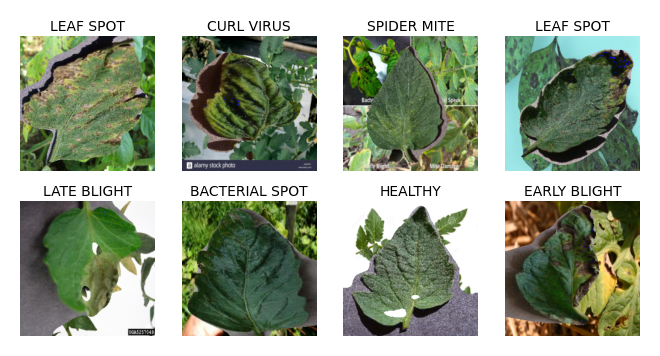

In [ ]:
a,b = train_data.get_batch(8,"TOMATO")
show_batch_img(a,le.inverse_transform(b))

In [ ]:
# show_batch_img(b_img,l_img)

In [ ]:
# a,b = train_data.get_batch(10,"TOMATO")
# show_batch_img(a,b)

#**TRAINING FUNCTIONS**

In [ ]:
def train_batch(net,criterion,data,lr=0.0001,batch_size=128,epochs=1000,plant_name="TOMATO",display=True,device='cpu'):
    min_loss = 1000
    loss_arr=[]
    opt = optim.Adam(net.parameters(),lr=lr)

    for i in range(epochs):
        net.train().to(device)
        opt.zero_grad()
        img_batch,label_batch = data.get_batch(batch_size,plant_name,1)
        img_batch,label_batch = img_batch.to(device),label_batch.to(device)    

        output = net(img_batch)
        loss = criterion(output,label_batch.long())

        loss.backward()
        opt.step()
        if loss<min_loss:
            best_model = net
            min_loss=loss
            print("Min loss model saved with LOSS= ",min_loss)

        loss_arr.append(loss)
        if display and (i%10==0):

            clear_output(wait=True)
            print('Iteration',i,'Loss',loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[0:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
    
    return loss_arr,best_model

In [ ]:
def infer(net,inputs,le=None,original=False,device="cpu"):
    net.to(device)
    pred_outputs = net(inputs)

    pred_output_labels = torch.argmax(pred_outputs,1)
    # if original:
    #     pred_output_labels = le.inverse_transform(pred_output_labels.to("cpu").numpy())
    
    return [pred_output_labels[i].item() for i in range(len(pred_output_labels))]

In [ ]:
def calc_accuracy(net,test_data,batch_size=128,device='cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(test_data.n["TOMATO"]):          #tr_epochs
        images,labels = test_data.get_batch(batch_size,flag=1)
        images,labels = images.to(device), labels.to(device)
        outputs = infer(net,images,device=device)
        correct = 0
        for index,out in enumerate(outputs):
            if out == labels[index]:
                correct+=1

        accuracy+=correct/len(outputs)

    accuracy/=len(test_data)
    return accuracy

In [ ]:
def predict(net,data,batch_size=1,plant_name="TOMATO",device="cpu"):
    img,label = data.get_batch(batch_size,"TOMATO",1)
    img = img.to(device)
    max_val,pred_label = torch.max(net(img),1)
    pred_label = le.inverse_transform(pred_label.to("cpu").numpy())
    true_label = le.inverse_transform(np.array(label,dtype=np.int))
    d = {"TRUE LABEL":true_label,"PREDICTED LABEL":pred_label}
    df = pd.DataFrame(d)
    print(tabulate(df, headers='keys', tablefmt='psql'))
    #print("The true class is",)
    #print("The predicted class is",pred_label)

#**PLANT VILLAGE DATASET**

##**TRAINING**

Test Train Split and Label Encodings

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(image_dict_saved["TOMATO"],
                                               label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=label_dict_saved["TOMATO"],
                                               random_state=0)

Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
# le_file = open("label_enc","wb")
# pickle.dump(le,le_file) 
# label_encoder_file = open("label_encoder","wb")
# pickle.dump(le,label_encoder_file)
# label_encoder_file.close()

In [ ]:
train_img_dict = {}
val_img_dict={}
train_label_dict={}
val_label_dict={}
train_img_dict["TOMATO"] = X_train
val_img_dict["TOMATO"] = X_val
train_label_dict["TOMATO"] = Y_L_train
val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,train_img_dict,train_label_dict)
val_data = PlantImageDataloader(path,image_transform,val_img_dict,val_label_dict)

##**RESNET 50 MODEL**

In [ ]:
resnet_structure = models.resnet50()
print(resnet_structure)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

###RESNET CASE-0: This model trains the fully connected layer of the original resnet model

In [ ]:
resnet_0 = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_0.parameters():
    param.requires_grad_(False)

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_0.fc.in_features
resnet_0.fc = nn.Sequential(
                 nn.Linear(final_in_features,new_out_features),
                 nn.Softmax())

TRAINING

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
resnet_0_loss_arr,best_resnet_0 = train_batch(resnet_0,criterion,train_data,lr=0.00005,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_resnet_0,val_data,128,device=device_gpu)

In [ ]:
torch.save(best_resnet_0,"resnet_0.1")

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_0.1"
resnet_0 = torch.load(path)

In [ ]:
resnet_0_loss_arr_1,best_resnet_0_1 = train_batch(resnet_0,criterion,train_data,lr=0.00001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_resnet_0_1,val_data,128,device=device_gpu)

In [ ]:
predict(best_resnet_0,val_data,10,device=device_gpu)

###RESNET CASE-1: This model trains the last conv2d and the fully connected layer of the original resnet model

In [ ]:
resnet_1 = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_1.parameters():
    param.requires_grad_(False)

Referring to the above resnet50 structure we will unfreeze some parts of the third bottleneck of the layer4. We will also change the fully connected layer in the end to match the number of labels availabe for our disease.
 

In [ ]:
"""Unfreezing the conv3,bn3 adn relu layer of the third bottleneck of the layer4"""
count = 0
for param in resnet_1.layer4[2].parameters():
    if count>=6:
        param.requires_grad_(True)
    count+=1

In [ ]:
new_out_features = 10           #total number of dieseas for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_1.fc.in_features
resnet_1.fc = nn.Sequential(
                 nn.Linear(final_in_features,new_out_features),
                 nn.Softmax())

In [ ]:
summary(resnet_1, (3,224,224),device="cpu")         #trainable parameters are 10,73,162

TRAINING

In [ ]:
criterion = nn.CrossEntropyLoss()
resnet_1_loss_arr,best_resnet_1 = train_batch(resnet_1,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
criterion = nn.CrossEntropyLoss()
resnet_1_loss_arr,best_resnet_1 = train_batch(resnet_1,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(resnet_1,val_data,128,device_gpu)

In [ ]:
torch.save(best_resnet_1,"resnet_1.1")

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_1.1"
saved_resnet_1 = torch.load(path)

In [ ]:
calc_accuracy(saved_resnet_1,val_data,128,device_gpu)

In [ ]:
resnet_1_loss_arr,best_resnet_1 = train_batch(saved_resnet_1,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
predict(saved_resnet_1,train_data,10,device=device_gpu)

###RESNET CASE-2: This model trains the last two convolutional layers along with the fully connected layer of the original resnet model

In [ ]:
resnet_2 = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_2.parameters():
    param.requires_grad_(False)

In [ ]:
"""Unfreezing the conv3,bn3 adn relu layer of the third bottleneck of the layer4"""
count = 0
for param in resnet_2.layer4[2].parameters():
    if count>=3:
        param.requires_grad_(True)
    count+=1

In [ ]:
new_out_features = 10           #total number of dieseas for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_2.fc.in_features
resnet_2.fc = nn.Linear(final_in_features,new_out_features)

In [ ]:
summary(resnet_2, (3, 224, 224),device="cpu")       #Trainable parameters are 34,33,482

TRAINING

Iteration 990 Loss tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward>)


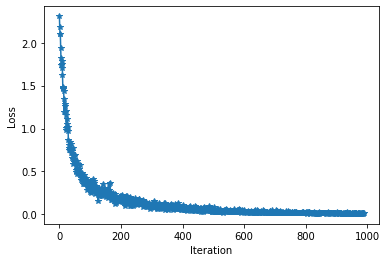

In [ ]:
criterion = nn.CrossEntropyLoss()
resnet_2_loss_arr = train_batch(resnet_2,criterion,train_data,lr=0.0001,batch_size=128,epochs=1000,device=device_gpu)

In [ ]:
calc_accuracy(resnet_2,val_data,128,device_gpu)

0.9750078059950041

In [ ]:
torch.save(resnet_2,"resnet_2.1")

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_2.1"
saved_resnet_2 = torch.load(path)

In [ ]:
resnet_2_loss_arr,best_resnet_2 = train_batch(saved_resnet_2,criterion,train_data,lr=0.0001,batch_size=128,epochs=1000,display=True,device=device_gpu)

In [ ]:
predict(saved_resnet_2,val_data,10,device=device_gpu)

+----+----------------+-------------------+
|    | TRUE LABEL     | PREDICTED LABEL   |
|----+----------------+-------------------|
|  0 | TARGET SPOT    | TARGET SPOT       |
|  1 | EARLY BLIGHT   | EARLY BLIGHT      |
|  2 | LEAF SPOT      | LEAF SPOT         |
|  3 | LEAF SPOT      | LEAF SPOT         |
|  4 | SPIDER MITE    | SPIDER MITE       |
|  5 | TARGET SPOT    | TARGET SPOT       |
|  6 | LEAF SPOT      | LEAF SPOT         |
|  7 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  8 | HEALTHY        | HEALTHY           |
|  9 | LATE BLIGHT    | LATE BLIGHT       |
+----+----------------+-------------------+


## **TRAINING RESNET FROM SCRATCH ON PLANTVILLAGE**

In [ ]:
scratch_resnet_plantvillage = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
"""Freeze all the layers of the resnet"""
for param in scratch_resnet_plantvillage.parameters():
    param.requires_grad_(True)

Iteration 1490 Loss tensor(0.0050, device='cuda:0', grad_fn=<NllLossBackward>)


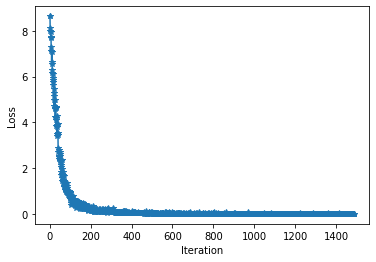

In [ ]:
criterion = nn.CrossEntropyLoss()
scratch_resnet_loss_arr,scratch_resnet_bm = train_batch(scratch_resnet_plantvillage,criterion,train_data,lr=0.00001,batch_size=128,epochs=1500,device=device_gpu)

In [ ]:
calc_accuracy(scratch_resnet_bm,val_data,128,device_gpu)

0.9791157108659451

In [ ]:
torch.save(scratch_resnet_bm,"scratch_resnet_plantvillage(97.9%)")

##**Inception+Resnet**


###MODEL DEFINITION

In [ ]:
class inception_block(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = nn.Conv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            nn.Conv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
c_resnet = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in c_resnet.parameters():
    param.requires_grad_(False)

In [ ]:
print(c_resnet.layer4)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [ ]:
c_resnet.layer4[0] = inception_block(1024,2048)
c_resnet.layer4[1] = inception_block(2048,2048)
c_resnet.layer4[2] = inception_block(2048,2048)
c_resnet.fc = nn.Linear(2048,10)

In [ ]:
print(c_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

###TRAINING INCEPTION-RESNET

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 990 Loss tensor(0.0629, device='cuda:0', grad_fn=<NllLossBackward>)


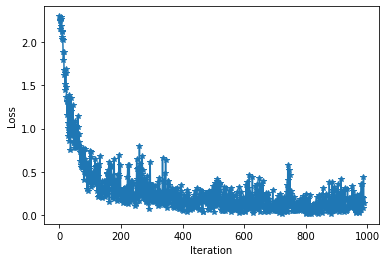




Min loss model saved with LOSS=  tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
c_resnet_loss_arr,inc_resnet_best_model_1 = train_batch(c_resnet,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(inc_resnet_best_model_1,val_data,128,device_gpu)

0.9816851842214821

In [ ]:
torch.save(inc_resnet_best_model_1,"inc_resnet_4")

In [ ]:
predict(inc_resnet_best_model,val_data,10,device=device_gpu)

+----+----------------+-------------------+
|    | TRUE LABEL     | PREDICTED LABEL   |
|----+----------------+-------------------|
|  0 | TARGET SPOT    | TARGET SPOT       |
|  1 | EARLY BLIGHT   | EARLY BLIGHT      |
|  2 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  3 | CURL VIRUS     | CURL VIRUS        |
|  4 | TARGET SPOT    | TARGET SPOT       |
|  5 | LEAF SPOT      | LEAF SPOT         |
|  6 | CURL VIRUS     | CURL VIRUS        |
|  7 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  8 | SPIDER MITE    | SPIDER MITE       |
|  9 | SPIDER MITE    | SPIDER MITE       |
+----+----------------+-------------------+


###INCRESNET FROM SCRATCH

####MODEL DEFINITION

In [ ]:
class inception_block(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = nn.Conv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            nn.Conv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
scratch_incresnet_plantvillage = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
"""Freeze all the layers of the resnet"""
for param in scratch_incresnet_plantvillage.parameters():
    param.requires_grad_(True)

In [ ]:
print(scratch_incresnet_plantvillage.layer4)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [ ]:
scratch_incresnet_plantvillage.layer4[0] = inception_block(1024,2048)
scratch_incresnet_plantvillage.layer4[1] = inception_block(2048,2048)
scratch_incresnet_plantvillage.layer4[2] = inception_block(2048,2048)
scratch_incresnet_plantvillage.fc = nn.Linear(2048,10)

In [ ]:
print(scratch_incresnet_plantvillage)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

####TRAINING PROCESS FROM SCRATCH INCRESNET

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 1490 Loss tensor(0.0347, device='cuda:0', grad_fn=<NllLossBackward>)


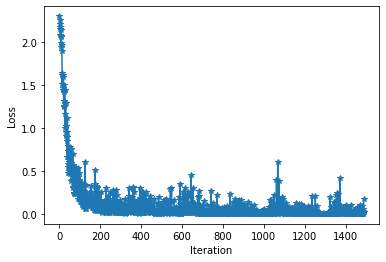

In [ ]:
scratch_incresnet_loss_arr,scratch_incresnet_best_model = train_batch(scratch_incresnet_plantvillage,criterion,train_data,lr=0.0001,batch_size=64,epochs=1500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_incresnet_best_model,val_data,128,device_gpu)

0.9900115788925895

In [ ]:
torch.save(scratch_incresnet_best_model,"scratch_incresnet_plantvillage(99%)")

###EXTRAS  inc resnet

Iteration 390 Loss tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward>)


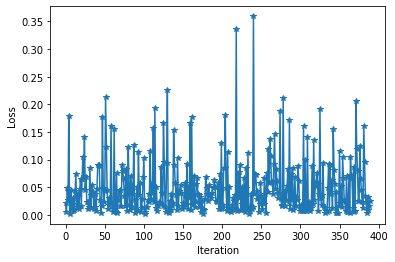

In [ ]:
c_resnet_loss_arr,inc_resnet_best_model_1 = train_batch(inc_resnet_best_model,criterion,train_data,lr=0.00001,batch_size=32,epochs=400,display=True,device=device_gpu)

In [ ]:
calc_accuracy(c_resnet,val_data,128,device_gpu)

0.969211854704413

In [ ]:
calc_accuracy(inc_resnet_best_model,val_data,128,device_gpu)

0.9754794181931724

In [ ]:
torch.save(inc_resnet_best_model,"inception_resnet_3")

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Inception Resnet Models/inception_resnet_3"
inc_resnet_best_model = torch.load(path)

Iteration 490 Loss tensor(0.0199, device='cuda:0', grad_fn=<NllLossBackward>)


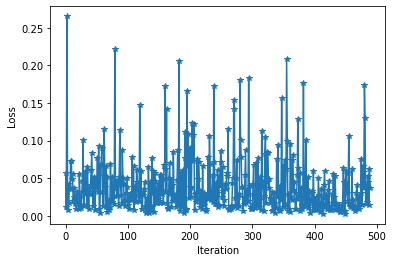

In [ ]:
inc_resnet_loss_arr,inc_resnet_best_model_1 = train_batch(inc_resnet_best_model,criterion,train_data,lr=0.0000001,batch_size=64,epochs=500,display=True,device=device_gpu)

#**PLANTDOC DATASET**

##**TRAINING**

In [ ]:
X_train_plantdoc,X_val_plantdoc,Y_train_plantdoc,Y_val_plantdoc = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc = le.transform(Y_train_plantdoc)
Y_L_val_plantdoc = le.transform(Y_val_plantdoc)

In [ ]:
plantdoc_train_img_dict = {}
plantdoc_val_img_dict={}
plantdoc_train_label_dict={}
plantdoc_val_label_dict={}
plantdoc_train_img_dict["TOMATO"] = X_train_plantdoc
plantdoc_val_img_dict["TOMATO"] = X_val_plantdoc
plantdoc_train_label_dict["TOMATO"] = Y_L_train_plantdoc
plantdoc_val_label_dict["TOMATO"] = Y_L_val_plantdoc

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict,plantdoc_train_label_dict)
plantdoc_val_data = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict,plantdoc_val_label_dict)

##**RESNET-50 FOR PLANTDOC**

###**RESNET-0 FOR PLANTDOC**

In [ ]:
resnet0_path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_0.1"
pd_resnet0 = torch.load(resnet0_path)

In [ ]:
calc_accuracy(pd_resnet0,plantdoc_val_data,64,device_gpu)

0.23973651960784315

Iteration 490 Loss tensor(2.1443, device='cuda:0', grad_fn=<NllLossBackward>)


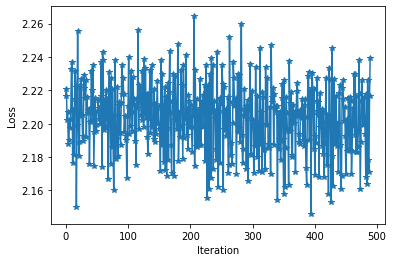

In [ ]:
l_r0,bm_r0 = train_batch(pd_resnet0,criterion,plantdoc_train_data,lr=0.000001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_r0,plantdoc_val_data,64,device_gpu)

0.2610294117647059

###**RESNET-1 FOR PLANTDOC**

In [ ]:
resnet1_path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_1.1"
pd_resnet1 = torch.load(resnet1_path)

In [ ]:
calc_accuracy(pd_resnet1,plantdoc_val_data,64,device_gpu)

0.29518995098039214

Iteration 490 Loss tensor(2.2205, device='cuda:0', grad_fn=<NllLossBackward>)


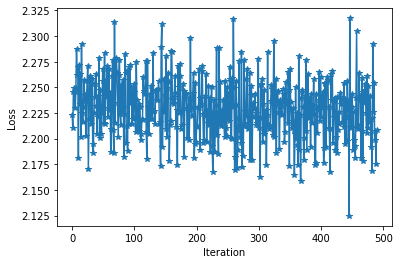

In [ ]:
l_r1,bm_r1 = train_batch(pd_resnet1,criterion,plantdoc_train_data,lr=0.000001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_r1,plantdoc_val_data,64,device_gpu)

0.21001838235294118

###**RESNET-2 FOR PLANTDOC**

In [ ]:
resnet2_path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_2.1"
pd_resnet2 = torch.load(resnet2_path)

In [ ]:
calc_accuracy(pd_resnet2,plantdoc_val_data,64,device_gpu)

0.2725183823529412

Iteration 490 Loss tensor(3.1146, device='cuda:0', grad_fn=<NllLossBackward>)


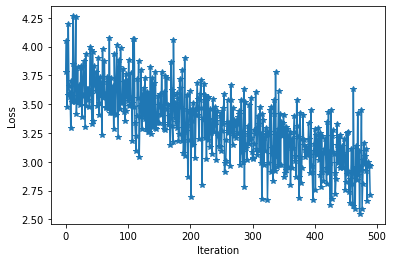




Min loss model saved with LOSS=  tensor(2.3441, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
l_r2,bm_r2 = train_batch(pd_resnet2,criterion,plantdoc_train_data,lr=0.000001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_r2,plantdoc_val_data,64,device_gpu)

0.2545955882352941

###**TRAINING RESNET FROM SCRATCH FOR PLANTDOC**

In [ ]:
scratch_resnet_plantdoc = models.resnet50()

In [ ]:
"""Freeze all the layers of the resnet"""
for param in scratch_resnet_plantdoc.parameters():
    param.requires_grad_(True)

Iteration 1490 Loss tensor(0.5776, device='cuda:0', grad_fn=<NllLossBackward>)


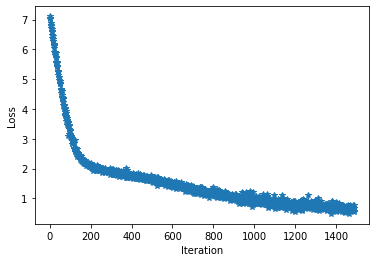

In [ ]:
scratch_resnet_l_r,scratch_resnet_bm = train_batch(scratch_resnet_plantdoc,criterion,plantdoc_train_data,lr=0.00001,batch_size=128,epochs=1500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_resnet_bm,plantdoc_val_data,64,device_gpu)

0.26516544117647056

In [ ]:
torch.save(scratch_resnet_bm,"scratch_resnet_plantdoc(26.5%)")

##**INC-RESNET FOR PLANTDOC**

In [ ]:
# incresnet_path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Inception Resnet Models/inception_resnet_4"
# pd_incresnet = torch.load(incresnet_path)

In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Inception Resnet Models/inception_resnet_4"
plantdoc_inc_resnet = torch.load(path)

Iteration 490 Loss tensor(0.6683, device='cuda:0', grad_fn=<NllLossBackward>)


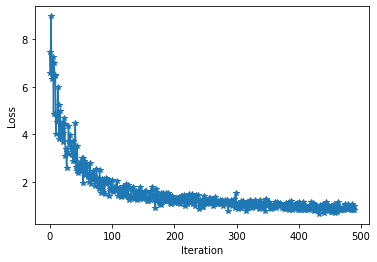

In [ ]:
pd_l,pd_bm = train_batch(plantdoc_inc_resnet,criterion,plantdoc_train_data,lr=0.00001,batch_size=64,epochs=500,display=True,device=device_gpu)

Iteration 490 Loss tensor(0.8497, device='cuda:0', grad_fn=<NllLossBackward>)


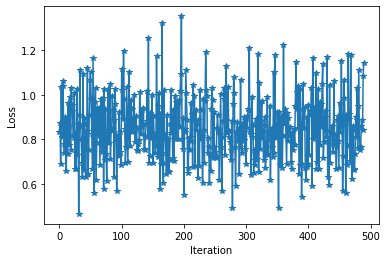

In [ ]:
pd_l2,pd_bm2 = train_batch(pd_bm,criterion,plantdoc_train_data,lr=0.0000001,batch_size=32,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(pd_incresnet,plantdoc_val_data,64,device_gpu)

0.27205882352941174

In [ ]:
predict(pd_bm,plantdoc_val_data,10,device=device_gpu)

+----+----------------+-------------------+
|    | TRUE LABEL     | PREDICTED LABEL   |
|----+----------------+-------------------|
|  0 | LEAF MOLD      | LATE BLIGHT       |
|  1 | BACTERIAL SPOT | LEAF SPOT         |
|  2 | BACTERIAL SPOT | LATE BLIGHT       |
|  3 | LEAF MOLD      | LEAF MOLD         |
|  4 | BACTERIAL SPOT | LEAF MOLD         |
|  5 | LEAF SPOT      | LEAF SPOT         |
|  6 | LEAF MOLD      | LEAF MOLD         |
|  7 | LEAF SPOT      | BACTERIAL SPOT    |
|  8 | CURL VIRUS     | LEAF MOLD         |
|  9 | LEAF SPOT      | LEAF SPOT         |
+----+----------------+-------------------+


##**TRAINING INC RESNET FROM SCRATCH**

####MODEL DEFINITION

In [ ]:
class inception_block(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = nn.Conv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            nn.Conv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
scratch_incresnet_plantdoc = models.resnet50(pretrained=True)
#scratch_incresnet_plantdoc = models.resnet50()

In [ ]:
"""Freeze all the layers of the resnet"""
for param in scratch_incresnet_plantdoc.parameters():
    param.requires_grad_(True)

In [ ]:
print(scratch_incresnet_plantdoc.layer4)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [ ]:
scratch_incresnet_plantdoc.layer4[0] = inception_block(1024,2048)
scratch_incresnet_plantdoc.layer4[1] = inception_block(2048,2048)
scratch_incresnet_plantdoc.layer4[2] = inception_block(2048,2048)
scratch_incresnet_plantdoc.fc = nn.Linear(2048,10)

In [ ]:
print(scratch_incresnet_plantdoc)

###TRAINING PROCESS FROM SCRATCH INCRESNET

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 1490 Loss tensor(0.1085, device='cuda:0', grad_fn=<NllLossBackward>)


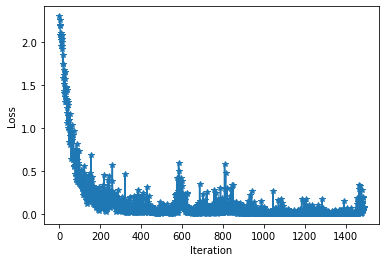

In [ ]:
scratch_incresnet_loss_arr,scratch_incresnet_best_model2 = train_batch(scratch_incresnet_plantdoc,criterion,plantdoc_train_data,lr=0.0001,batch_size=64,epochs=1500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_incresnet_best_model2,plantdoc_val_data,128,device_gpu)

0.5899969362745098

In [ ]:
torch.save(scratch_incresnet_best_model2,"scratch_incresnet_plantdoc2(58.9%)")

##**TRAINING ATTEMPTS**

Iteration 490 Loss tensor(2.0286, device='cuda:0', grad_fn=<NllLossBackward>)


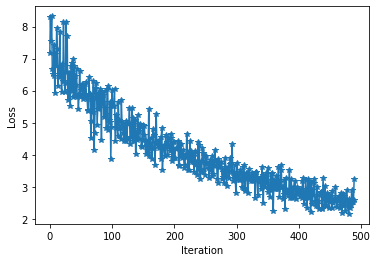

In [ ]:
# l_incr,bm_incr = train_batch(pd_incresnet,criterion,plantdoc_train_data,lr=0.000001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
# calc_accuracy(bm_incr,plantdoc_val_data,64,device_gpu)

0.3795955882352941

Iteration 490 Loss tensor(1.5957, device='cuda:0', grad_fn=<NllLossBackward>)


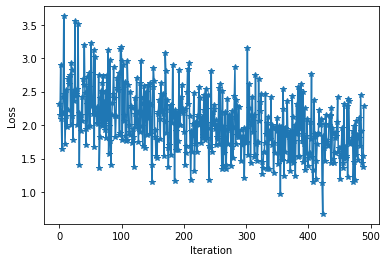

In [ ]:
# l_incr2,bm_incr2 = train_batch(bm_incr,criterion,plantdoc_train_data,lr=0.000001,batch_size=32,epochs=500,display=True,device=device_gpu)

In [ ]:
# calc_accuracy(bm_incr2,plantdoc_val_data,64,device_gpu)

0.4178921568627451

Iteration 490 Loss tensor(1.7971, device='cuda:0', grad_fn=<NllLossBackward>)


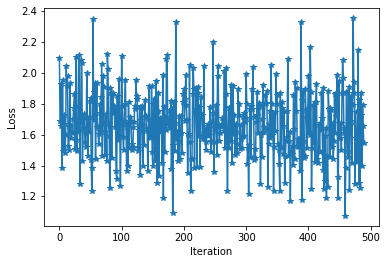

In [ ]:
# l_incr3,bm_incr3 = train_batch(bm_incr2,criterion,plantdoc_train_data,lr=0.0000001,batch_size=64,epochs=500,display=True,device=device_gpu)

In [ ]:
#calc_accuracy(bm_incr3,plantdoc_val_data,64,device_gpu)

0.42401960784313725

Iteration 1490 Loss tensor(0.0176, device='cuda:0', grad_fn=<NllLossBackward>)


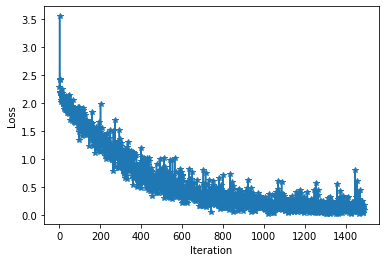

In [ ]:
scratch_incresnet_loss_arr,scratch_incresnet_best_model = train_batch(scratch_incresnet_plantdoc,criterion,plantdoc_train_data,lr=0.0001,batch_size=64,epochs=1500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_incresnet_best_model,plantdoc_val_data,128,device_gpu)

0.4075520833333333

In [ ]:
torch.save(scratch_incresnet_best_model,"scratch_incresnet_plantdoc(40.7%)")

###**SUBSECTION2**

In [ ]:
# pd_c_resnet = models.resnet50(pretrained=True)

In [ ]:
# """Freeze all the layers of the resnet"""
# for param in pd_c_resnet.parameters():
#     param.requires_grad_(False)

In [ ]:
# pd_c_resnet.layer4[0] = inception_block(1024,2048)
# pd_c_resnet.layer4[1] = inception_block(2048,2048)
# pd_c_resnet.layer4[2] = inception_block(2048,2048)
# pd_c_resnet.fc = nn.Linear(2048,10)

In [ ]:
# path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
# train_data_1 = PlantImageDataloader3(path,image_transform,train_img_dict,train_label_dict)
# val_data_1 = PlantImageDataloader3(path,image_transform,val_img_dict,val_label_dict)

Iteration 490 Loss tensor(0.7222, device='cuda:0', grad_fn=<NllLossBackward>)


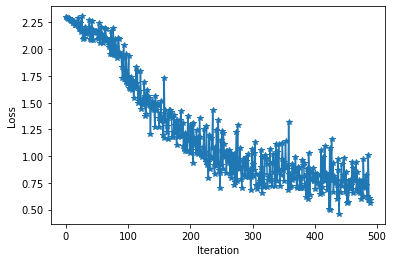

In [ ]:
# l_1,bm_1 = train_batch(pd_c_resnet,criterion,train_data_1,lr=0.00001,batch_size=64,epochs=500,display=True,device=device_gpu)

In [ ]:
# calc_accuracy(bm_1,val_data_1,64,device_gpu)

In [ ]:
# torch.save(bm_1,"inc_resnet_aug_1")

Iteration 490 Loss tensor(0.7693, device='cuda:0', grad_fn=<NllLossBackward>)


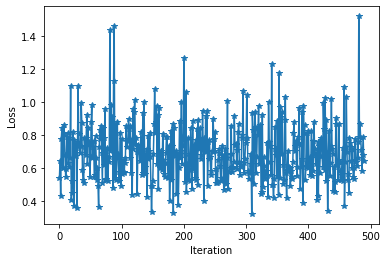

In [ ]:
# l_2,bm_2 = train_batch(bm_1,criterion,train_data_1,lr=0.000001,batch_size=32,epochs=500,display=True,device=device_gpu)

In [ ]:
# calc_accuracy(bm_2,val_data_1,32,device_gpu)            #this is plantvillage

0.7790643213988343

In [ ]:
# torch.save(bm_2,"inc_resnet_aug_2")

In [ ]:
# pd_l_1,pd_bm_1 = train_batch(bm_1,criterion,plantdoc_train_data,lr=0.00001,batch_size=64,epochs=500,display=True,device=device_gpu)

#**CREATION OF NEW DATASET THROUGH MASK**


In [ ]:
# path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"
# image_dict_file= open(f"{path_load}/images_dict1.pkl","rb")
# label_dict_file= open(f"{path_load}/labels_dict1.pkl","rb")
# image_dict_saved = pickle.load(image_dict_file)
# label_dict_saved = pickle.load(label_dict_file)

In [ ]:
# plantdoc_path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code"
# plantdoc_image_dict_file= open(f"{plantdoc_path_load}/plantdoc_trainimages_dict.pkl","rb")
# plantdoc_label_dict_file= open(f"{plantdoc_path_load}/plantdoc_trainlabels_dict.pkl","rb")
# plantdoc_image_dict_saved = pickle.load(plantdoc_image_dict_file)
# plantdoc_label_dict_saved = pickle.load(plantdoc_label_dict_file)

In [ ]:
def unnormalize(img_tensor):
    x = img_tensor.numpy()
    x = (x*0.5)+0.5
    return torch.Tensor(x)

In [ ]:
def apply_mask(pv_img, pd_img):
    pv = np.array(pv_img)
    pd = np.array(pd_img)
    temp1 = get_mask(pv)
    temp2 = temp1.copy()
    temp3 = temp1.copy()
    temp2[temp1==0] = 255
    temp2[(temp1>0)] = 0
    temp3[pv==0] = 255
    final = cv2.bitwise_and(temp2,pd)+temp3
    return final

In [ ]:
def get_mask(color_img):
    """pv is the color image of plant village in numpy array format"""
    im_gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(im_gray,(55,55),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    final_img = cv2.bitwise_and(color_img,color_img,mask=th)
    return final_img

In [ ]:
new_dataset_imgs = {}
new_dataset_labels = {}
new_dataset_imgs["TOMATO"] = []
new_dataset_labels["TOMATO"] = []

for i,label in enumerate(label_dict_saved["TOMATO"]):
    try:
        temp = [unnormalize(plantdoc_image_dict_saved["TOMATO"][j]) for j in range(len(plantdoc_label_dict_saved["TOMATO"])) if plantdoc_label_dict_saved["TOMATO"][j]==label]
        r = random.randint(0,len(temp)-1)
        pd_img = transforms.ToPILImage()(temp[r])
        pv_img = transforms.ToPILImage()(unnormalize(image_dict_saved["TOMATO"][i]))
        temp2 = apply_mask(pv_img,pd_img)
        temp2 = np.transpose(temp2,(2,0,1))
        temp2 = temp2/255
        final_tensor = torch.Tensor(temp2)
        final_tensor = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))(final_tensor)
        new_dataset_imgs["TOMATO"].append(final_tensor)
        new_dataset_labels["TOMATO"].append(label)
        if i%100==0:
            print("Read",i,"images")
    except Exception as e:
        print(f"Error : {e}")

Read 0 images
Read 100 images
Read 200 images
Read 300 images
Read 400 images
Read 500 images
Read 600 images
Read 700 images
Read 800 images
Read 900 images
Read 1000 images
Read 1100 images
Read 1200 images
Read 1300 images
Read 1400 images
Read 1500 images
Read 1600 images
Read 1700 images
Read 1800 images
Read 1900 images
Read 2000 images
Read 2100 images
Read 2200 images
Read 2300 images
Read 2400 images
Read 2500 images
Read 2600 images
Read 2700 images
Read 2800 images
Read 2900 images
Read 3000 images
Read 3100 images
Read 3200 images
Read 3300 images
Read 3400 images
Read 3500 images
Read 3600 images
Read 3700 images
Read 3800 images
Read 3900 images
Read 4000 images
Read 4100 images
Read 4200 images
Read 4300 images
Read 4400 images
Read 4500 images
Read 4600 images
Read 4700 images
Read 4800 images
Read 4900 images
Read 5000 images
Read 5100 images
Read 5200 images
Read 5300 images
Read 5400 images
Read 5500 images
Read 5600 images
Read 5700 images
Read 5800 images
Read 5900

In [ ]:
path = f""
data = PlantImageDataloader(path,image_transform,images_dict=new_dataset_imgs,labels_dict=new_dataset_labels)
a,b = data.get_batch(20,"TOMATO")

In [ ]:
image_file = open("newdataset_images_dict.pkl","wb")
label_file = open("new_dataset_labels_dict.pkl","wb")
pickle.dump(new_dataset_imgs,image_file)
pickle.dump(new_dataset_labels,label_file)
image_file.close()
label_file.close()

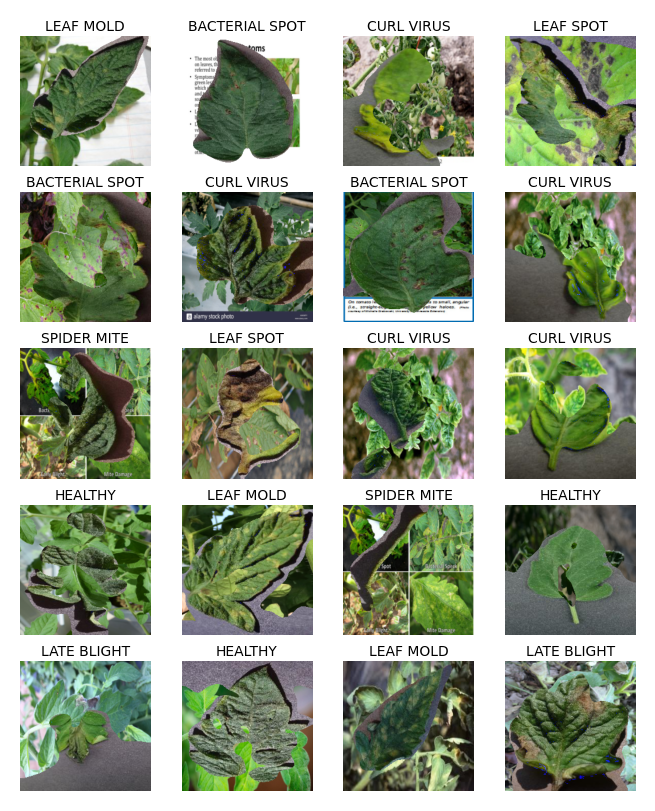

In [ ]:
show_batch_img(a,b)

#**NEW AUGMENTED DATASET**

##TRAINING

###PLANTDOC BASIC VALIDATION DATA

METHOD1

In [ ]:
# X_train_plantdoc,X_val_plantdoc,Y_train_plantdoc,Y_val_plantdoc = train_test_split(plantdoc_image_dict_saved["TOMATO"],
#                                                plantdoc_label_dict_saved["TOMATO"],
#                                                test_size=0.15,
#                                                stratify=plantdoc_label_dict_saved["TOMATO"],
#                                                random_state=0)

In [ ]:
# Y_L_train_plantdoc = le.transform(Y_train_plantdoc)
# Y_L_val_plantdoc = le.transform(Y_val_plantdoc)

In [ ]:
# plantdoc_train_img_dict = {}
# plantdoc_val_img_dict={}
# plantdoc_train_label_dict={}
# plantdoc_val_label_dict={}
# plantdoc_train_img_dict["TOMATO"] = X_train_plantdoc
# plantdoc_val_img_dict["TOMATO"] = X_val_plantdoc
# plantdoc_train_label_dict["TOMATO"] = Y_L_train_plantdoc
# plantdoc_val_label_dict["TOMATO"] = Y_L_val_plantdoc

# path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
# plantdoc_train_data = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict,plantdoc_train_label_dict)
# plantdoc_val_data = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict,plantdoc_val_label_dict)

METHOD2

In [ ]:
X_train_plantdoc2,X_val_plantdoc2,Y_train_plantdoc2,Y_val_plantdoc2 = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.95,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc2 = le.transform(Y_train_plantdoc2)
Y_L_val_plantdoc2 = le.transform(Y_val_plantdoc2)

In [ ]:
plantdoc_train_img_dict2 = {}
plantdoc_val_img_dict2={}
plantdoc_train_label_dict2={}
plantdoc_val_label_dict2={}
plantdoc_train_img_dict2["TOMATO"] = X_train_plantdoc2
plantdoc_val_img_dict2["TOMATO"] = X_val_plantdoc2
plantdoc_train_label_dict2["TOMATO"] = Y_L_train_plantdoc2
plantdoc_val_label_dict2["TOMATO"] = Y_L_val_plantdoc2

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data2 = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict2,plantdoc_train_label_dict2)
plantdoc_val_data2 = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict2,plantdoc_val_label_dict2)

###Test Train Split and Label Encodings

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(new_dataset_imgs["TOMATO"],
                                               new_dataset_labels["TOMATO"],
                                               test_size=0.15,
                                               stratify=new_dataset_labels["TOMATO"],
                                               random_state=0)

#le = LabelEncoder()
# path_label = f"drive/My Drive/Aditya Arnav-CropDisease/Code/label_encoder"
# le_file = open(path_label,"rb")
# le = pickle.load(le_file)
Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
# label_encoder_file = open("label_encoder","wb")
# pickle.dump(le,label_encoder_file)
# label_encoder_file.close()

In [ ]:
new_dataset_train_img_dict = {}
new_dataset_val_img_dict={}
new_dataset_train_label_dict={}
new_dataset_val_label_dict={}
new_dataset_train_img_dict["TOMATO"] = X_train
new_dataset_val_img_dict["TOMATO"] = X_val
new_dataset_train_label_dict["TOMATO"] = Y_L_train
new_dataset_val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,new_dataset_train_img_dict,new_dataset_train_label_dict)
val_data = PlantImageDataloader(path,image_transform,new_dataset_val_img_dict,new_dataset_val_label_dict)

##RESNET CASE-0: This model trains the fully connected layer of the original resnet model

In [ ]:
resnet_0 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_0.parameters():
    param.requires_grad_(False)

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_0.fc.in_features
resnet_0.fc = nn.Sequential(
                 nn.Linear(final_in_features,new_out_features),
                 nn.Softmax())

TRAINING

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 990 Loss tensor(1.8519, device='cuda:0', grad_fn=<NllLossBackward>)


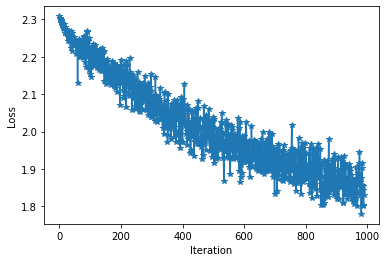

In [ ]:
resnet_0_loss_arr,best_resnet_0 = train_batch(resnet_0,criterion,train_data,lr=0.00005,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_resnet_0,val_data,128,device=device_gpu)

0.7449995723083942

In [ ]:
calc_accuracy(best_resnet_0,plantdoc_val_data2,128,device_gpu)

0.33096811819595645

In [ ]:
torch.save(best_resnet_0,"newdataset_resnet_0.1(74%,33%)")

In [ ]:
predict(best_resnet_0,val_data,10,device=device_gpu)

+----+----------------+-------------------+
|    | TRUE LABEL     | PREDICTED LABEL   |
|----+----------------+-------------------|
|  0 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  1 | CURL VIRUS     | CURL VIRUS        |
|  2 | SPIDER MITE    | SPIDER MITE       |
|  3 | SPIDER MITE    | SPIDER MITE       |
|  4 | SPIDER MITE    | SPIDER MITE       |
|  5 | SPIDER MITE    | SPIDER MITE       |
|  6 | CURL VIRUS     | CURL VIRUS        |
|  7 | BACTERIAL SPOT | LEAF SPOT         |
|  8 | BACTERIAL SPOT | CURL VIRUS        |
|  9 | LATE BLIGHT    | LATE BLIGHT       |
+----+----------------+-------------------+


###EXTRAS

In [ ]:
# path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_0.1"
# resnet_0 = torch.load(path)

Iteration 490 Loss tensor(1.7431, device='cuda:0', grad_fn=<NllLossBackward>)


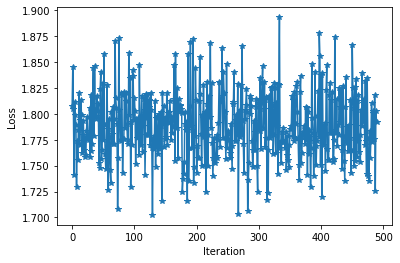

In [ ]:
# resnet_0_loss_arr_1,best_resnet_0_1 = train_batch(resnet_0,criterion,train_data,lr=0.00001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
# calc_accuracy(best_resnet_0_1,val_data,128,device=device_gpu)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.7267413873855121

##RESNET CASE-1: This model trains the last conv2d and the fully connected layer of the original resnet model

In [ ]:
resnet_1 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_1.parameters():
    param.requires_grad_(False)

Referring to the above resnet50 structure we will unfreeze some parts of the third bottleneck of the layer4. We will also change the fully connected layer in the end to match the number of labels availabe for our disease.
 

In [ ]:
"""Unfreezing the conv3,bn3 adn relu layer of the third bottleneck of the layer4"""
count = 0
for param in resnet_1.layer4[2].parameters():
    if count>=6:
        param.requires_grad_(True)
    count+=1

In [ ]:
new_out_features = 10           #total number of dieseas for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_1.fc.in_features
resnet_1.fc = nn.Sequential(
                 nn.Linear(final_in_features,new_out_features),
                 nn.Softmax())

In [ ]:
summary(resnet_1, (3,224,224),device="cpu")         #trainable parameters are 10,73,162

TRAINING

Iteration 990 Loss tensor(1.6318, device='cuda:0', grad_fn=<NllLossBackward>)


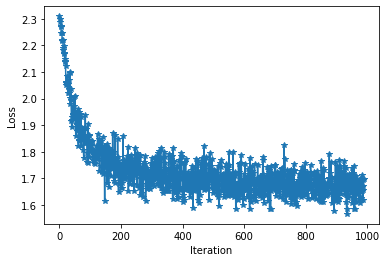

In [ ]:
criterion = nn.CrossEntropyLoss()
resnet_1_loss_arr,best_resnet_1 = train_batch(resnet_1,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_resnet_1,val_data,128,device_gpu)

0.7910548300638686

In [ ]:
calc_accuracy(best_resnet_1,plantdoc_val_data2,128,device_gpu)

0.4176832231726283

In [ ]:
calc_accuracy(best_resnet_1,val_data,128,device_gpu)

0.8315536610401459

In [ ]:
calc_accuracy(best_resnet_1,plantdoc_val_data2,128,device_gpu)

0.4403795684292379

In [ ]:
torch.save(best_resnet_1,"newdataset_resnet_1.1")

In [ ]:
# path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_1.1"
# saved_resnet_1 = torch.load(path)

In [ ]:
predict(best_resnet_1,train_data,10,device=device_gpu)

+----+----------------+-------------------+
|    | TRUE LABEL     | PREDICTED LABEL   |
|----+----------------+-------------------|
|  0 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  1 | LEAF MOLD      | LATE BLIGHT       |
|  2 | LATE BLIGHT    | LATE BLIGHT       |
|  3 | SPIDER MITE    | SPIDER MITE       |
|  4 | SPIDER MITE    | SPIDER MITE       |
|  5 | LEAF SPOT      | BACTERIAL SPOT    |
|  6 | LEAF SPOT      | LEAF SPOT         |
|  7 | LATE BLIGHT    | LATE BLIGHT       |
|  8 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  9 | SPIDER MITE    | SPIDER MITE       |
+----+----------------+-------------------+


##RESNET CASE-2: This model trains the last two convolutional layers along with the fully connected layer of the original resnet model

In [ ]:
resnet_2 = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_2.parameters():
    param.requires_grad_(False)

In [ ]:
"""Unfreezing the conv3,bn3 adn relu layer of the third bottleneck of the layer4"""
count = 0
for param in resnet_2.layer4[2].parameters():
    if count>=3:
        param.requires_grad_(True)
    count+=1

In [ ]:
new_out_features = 10           #total number of dieseas for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_2.fc.in_features
resnet_2.fc = nn.Linear(final_in_features,new_out_features)

In [ ]:
summary(resnet_2, (3, 224, 224),device="cpu")       #Trainable parameters are 34,33,482

**TRAINING**

Iteration 990 Loss tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward>)


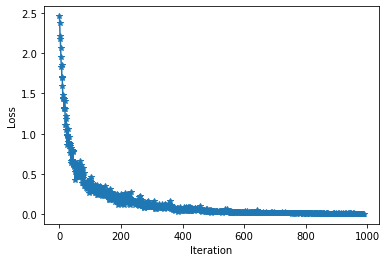

In [ ]:
criterion = nn.CrossEntropyLoss()
resnet_2_loss_arr,best_resnet_2 = train_batch(resnet_2,criterion,train_data,lr=0.0001,batch_size=128,epochs=1000,device=device_gpu)

In [ ]:
calc_accuracy(best_resnet_2,val_data,128,device_gpu)

0.9644196224908759

In [ ]:
calc_accuracy(best_resnet_2,plantdoc_val_data2,128,device_gpu)

0.6167500972006221

In [ ]:
calc_accuracy(best_resnet_2,val_data,128,device_gpu)

0.9671140796076643

In [ ]:
calc_accuracy(best_resnet_2,plantdoc_val_data2,128,device_gpu)

0.6241494945567652

In [ ]:
torch.save(best_resnet_2,"newdataset_resnet_2.1")

In [ ]:
# path = f"drive/My Drive/Aditya Arnav-CropDisease/Code/Resnet Models/resnet_2.1"
# saved_resnet_2 = torch.load(path)

In [ ]:
# resnet_2_loss_arr,best_resnet_2 = train_batch(saved_resnet_2,criterion,train_data,lr=0.0001,batch_size=128,epochs=1000,display=True,device=device_gpu)

In [ ]:
predict(saved_resnet_2,val_data,10,device=device_gpu)

+----+----------------+-------------------+
|    | TRUE LABEL     | PREDICTED LABEL   |
|----+----------------+-------------------|
|  0 | TARGET SPOT    | TARGET SPOT       |
|  1 | EARLY BLIGHT   | EARLY BLIGHT      |
|  2 | LEAF SPOT      | LEAF SPOT         |
|  3 | LEAF SPOT      | LEAF SPOT         |
|  4 | SPIDER MITE    | SPIDER MITE       |
|  5 | TARGET SPOT    | TARGET SPOT       |
|  6 | LEAF SPOT      | LEAF SPOT         |
|  7 | BACTERIAL SPOT | BACTERIAL SPOT    |
|  8 | HEALTHY        | HEALTHY           |
|  9 | LATE BLIGHT    | LATE BLIGHT       |
+----+----------------+-------------------+


##RESNET FROM SCRATCH FOR NEW DATASET

In [ ]:
scratch_resnet_newdataset = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
"""Freeze all the layers of the resnet"""
for param in scratch_resnet_newdataset.parameters():
    param.requires_grad_(True)

Iteration 1490 Loss tensor(8.8603e-05, device='cuda:0', grad_fn=<NllLossBackward>)


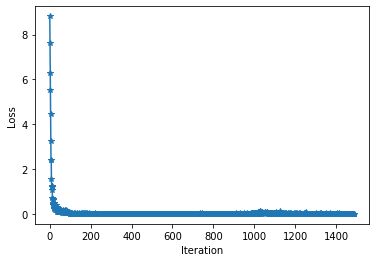

In [ ]:
criterion = nn.CrossEntropyLoss()
scratch_resnet_loss_arr,scratch_resnet_bm = train_batch(scratch_resnet_newdataset,criterion,train_data,lr=0.0001,batch_size=128,epochs=1500,device=device_gpu)

In [ ]:
calc_accuracy(scratch_resnet_bm,val_data,128,device_gpu)

0.9917990134580292

In [ ]:
calc_accuracy(scratch_resnet_bm,plantdoc_val_data2,128,device_gpu)

0.6529451788491446

In [ ]:
torch.save(scratch_resnet_bm,"scratch_resnet_newdataset(99%,65.3%)")

##INC RESNET FOR NEW DATASET

###INC RESNET MODEL DEFINITION

In [ ]:
class inception_block(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = nn.Conv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            nn.Conv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
newdataset_resnet = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in newdataset_resnet.parameters():
    param.requires_grad_(False)

In [ ]:
print(newdataset_resnet.layer4)

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [ ]:
newdataset_resnet.layer4[0] = inception_block(1024,2048)
newdataset_resnet.layer4[1] = inception_block(2048,2048)
newdataset_resnet.layer4[2] = inception_block(2048,2048)
newdataset_resnet.fc = nn.Linear(2048,10)

In [ ]:
print(newdataset_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

###INC RESNET TRAINING PROCESS

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 490 Loss tensor(0.0690, device='cuda:0', grad_fn=<NllLossBackward>)


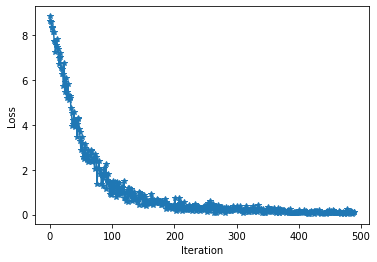

In [ ]:
new_l,new_bm = train_batch(newdataset_resnet,criterion,train_data,lr=0.00001,batch_size=64,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(new_bm,val_data,64,device_gpu)

0.9588917084854015

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data,64,device_gpu)

0.5200674019607843

In [ ]:
torch.save(new_bm,"newdataset_model_1.1(95%,52%)")

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data2,64,device_gpu)

0.5331211119751167

In [ ]:
torch.save(new_bm,"newdataset_model_1.1(95%,53%)")

In [ ]:
newdataset_path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code/NewDataset Models/newdataset_model_1.1"
new_model = torch.load(newdataset_path_load)

##INC RESNET TRAINING FROM SCRATCH (ALL LAYERS UNFREEZED)

###INC RESNET MODEL DEFINITION

In [ ]:
class inception_block(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = nn.Conv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            nn.Conv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
print(scratch_newdataset_incresnet)

In [ ]:
summary(scratch_newdataset_incresnet, (3,224,224),device="cpu")         #trainable parameters are 10,73,162

###TRAINING PROCESS

In [ ]:
scratch_newdataset_incresnet = models.resnet50(pretrained=True)

In [ ]:
# scratch_newdataset_incresnet

In [ ]:
"""Freeze all the layers of the resnet"""
for param in scratch_newdataset_incresnet.parameters():
    param.requires_grad_(True)

In [ ]:
scratch_newdataset_incresnet.layer3[4] = inception_block(1024,1024)
scratch_newdataset_incresnet.layer3[5] = inception_block(1024,1024)
scratch_newdataset_incresnet.layer4[0] = inception_block(1024,2048)
scratch_newdataset_incresnet.layer4[1] = inception_block(2048,2048)
# scratch_newdataset_incresnet.layer4[2] = inception_block(2048,2048)
scratch_newdataset_incresnet.fc = nn.Linear(2048,10)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 2490 Loss tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward>)


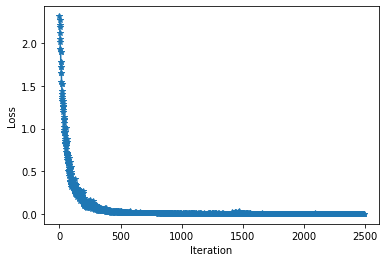

In [ ]:
scratch_new_l,scratch_new_bm = train_batch(scratch_newdataset_incresnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=2500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_new_bm,val_data,128,device_gpu)

0.9908687842153284

In [ ]:
calc_accuracy(scratch_new_bm,plantdoc_val_data2,128,device_gpu)

0.6606361780715396

In [ ]:
torch.save(scratch_new_bm,"scratch_newdataset_incresnet(99%,66%)")

###EXTRAS

In [ ]:
scratch_newdataset_incresnet = models.resnet50(pretrained=True)

In [ ]:
scratch_newdataset_incresnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
scratch_newdataset_incresnet.layer3[4] = inception_block(1024,1024)
scratch_newdataset_incresnet.layer3[5] = inception_block(1024,1024)
scratch_newdataset_incresnet.layer4[0] = inception_block(1024,2048)
scratch_newdataset_incresnet.layer4[1] = inception_block(2048,2048)
# scratch_newdataset_incresnet.layer4[2] = inception_block(2048,2048)
scratch_newdataset_incresnet.fc = nn.Linear(2048,10)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in scratch_newdataset_incresnet.parameters():
    param.requires_grad_(True)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 2490 Loss tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward>)


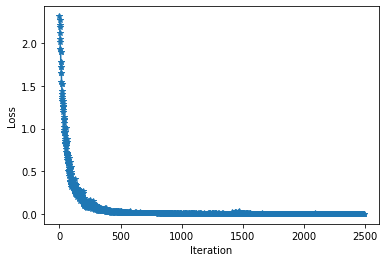

In [ ]:
scratch_new_l,scratch_new_bm = train_batch(scratch_newdataset_incresnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=2500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_new_bm,plantdoc_val_data2,128,device_gpu)

0.6606361780715396

In [ ]:
calc_accuracy(scratch_new_bm,val_data,128,device_gpu)

0.9908687842153284

In [ ]:
torch.save(scratch_new_bm,"scratch_newdataset_incresnet(66%)")

In [ ]:
summary(scratch_newdataset_incresnet, (3,224,224),device="cpu")

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 1490 Loss tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward>)


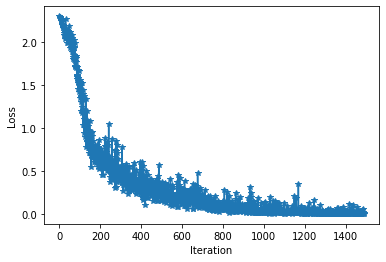

In [ ]:
scratch_new_l,scratch_new_bm = train_batch(scratch_newdataset_incresnet,criterion,train_data,lr=0.00001,batch_size=64,epochs=1500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_new_bm,val_data,64,device_gpu)

0.9712947650547445

In [ ]:
calc_accuracy(scratch_new_bm,plantdoc_val_data2,64,device_gpu)

0.531371500777605

In [ ]:
torch.save(scratch_new_bm,"scratch_newdataset_incresnet(53.13%)")

Iteration 1990 Loss tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward>)


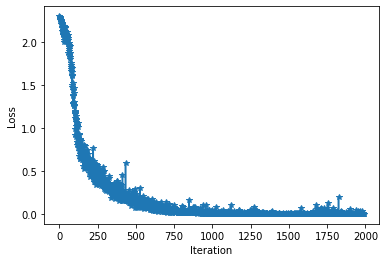

In [ ]:
scratch_new_l,scratch_new_bm = train_batch(scratch_newdataset_incresnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=2000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_new_bm,val_data,128,device_gpu)

0.9689353330291971

In [ ]:
calc_accuracy(scratch_new_bm,plantdoc_val_data2,128,device_gpu)

0.5451253888024883

In [ ]:
torch.save(scratch_new_bm,"scratch_incresnet_model")

In [ ]:
torch.cuda.empty_cache()

Iteration 90 Loss tensor(0.0394, device='cuda:0', grad_fn=<NllLossBackward>)


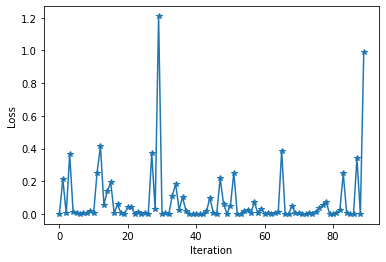

In [ ]:
scratch_new_l,scratch_new_bm = train_batch(scratch_new_bm,criterion,train_data,lr=0.00001,batch_size=32,epochs=100,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_new_bm,plantdoc_val_data2,32,device_gpu)

0.5117126749611197

In [ ]:
calc_accuracy(scratch_new_bm,plantdoc_val_data2,128,device_gpu)

0.5686357892690513

In [ ]:
calc_accuracy(scratch_new_bm,val_data,128,device_gpu)

0.9808572365419708

In [ ]:
torch.save(scratch_new_bm,"scratch_newdataset_incresnet(56.8%)")

Iteration 2490 Loss tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward>)


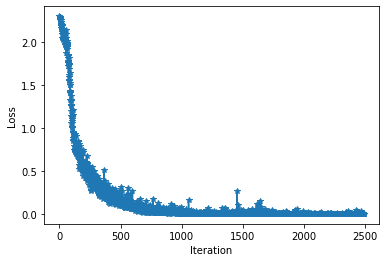

In [ ]:
scratch_new_l,scratch_new_bm = train_batch(scratch_newdataset_incresnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=2500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_new_bm,val_data,128,device_gpu)

In [ ]:
calc_accuracy(scratch_new_bm,plantdoc_val_data2,128,device_gpu)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.save(scratch_new_bm,"temp")

In [ ]:
scratch_newdataset_incresnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
"""Freeze all the layers of the resnet"""
for param in scratch_newdataset_incresnet.parameters():
    param.requires_grad_(True)

In [ ]:
scratch_newdataset_incresnet.layer4[0] = inception_block(1024,2048)
scratch_newdataset_incresnet.layer4[1] = inception_block(2048,2048)
scratch_newdataset_incresnet.layer4[2] = inception_block(2048,2048)
scratch_newdataset_incresnet.fc = nn.Linear(2048,10)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
scratch_new_l,scratch_new_bm = train_batch(scratch_newdataset_incresnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=2500,display=True,device=device_gpu)

Iteration 60 Loss tensor(2.3061, device='xla:1', grad_fn=<NllLossBackward>)


In [ ]:
path = f"drive/My Drive/Aditya Arnav-CropDisease/temp"
scratch_new_bm = torch.load(path,map_location='cpu')

In [ ]:
#scratch_new_bm = scratch_new_bm.to(device_gpu)

In [ ]:
calc_accuracy(scratch_new_bm,val_data,128,"cpu")

In [ ]:
calc_accuracy(scratch_new_bm,plantdoc_val_data2,128,device_gpu)

#**DEFORMABLE SECTION**

##TRAINING

###PLANTDOC BASIC VALIDATION DATA

METHOD1

In [ ]:
# X_train_plantdoc,X_val_plantdoc,Y_train_plantdoc,Y_val_plantdoc = train_test_split(plantdoc_image_dict_saved["TOMATO"],
#                                                plantdoc_label_dict_saved["TOMATO"],
#                                                test_size=0.15,
#                                                stratify=plantdoc_label_dict_saved["TOMATO"],
#                                                random_state=0)

In [ ]:
# Y_L_train_plantdoc = le.transform(Y_train_plantdoc)
# Y_L_val_plantdoc = le.transform(Y_val_plantdoc)

In [ ]:
# plantdoc_train_img_dict = {}
# plantdoc_val_img_dict={}
# plantdoc_train_label_dict={}
# plantdoc_val_label_dict={}
# plantdoc_train_img_dict["TOMATO"] = X_train_plantdoc
# plantdoc_val_img_dict["TOMATO"] = X_val_plantdoc
# plantdoc_train_label_dict["TOMATO"] = Y_L_train_plantdoc
# plantdoc_val_label_dict["TOMATO"] = Y_L_val_plantdoc

# path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
# plantdoc_train_data = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict,plantdoc_train_label_dict)
# plantdoc_val_data = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict,plantdoc_val_label_dict)

METHOD2

In [ ]:
X_train_plantdoc2,X_val_plantdoc2,Y_train_plantdoc2,Y_val_plantdoc2 = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.95,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc2 = le.transform(Y_train_plantdoc2)
Y_L_val_plantdoc2 = le.transform(Y_val_plantdoc2)

In [ ]:
plantdoc_train_img_dict2 = {}
plantdoc_val_img_dict2={}
plantdoc_train_label_dict2={}
plantdoc_val_label_dict2={}
plantdoc_train_img_dict2["TOMATO"] = X_train_plantdoc2
plantdoc_val_img_dict2["TOMATO"] = X_val_plantdoc2
plantdoc_train_label_dict2["TOMATO"] = Y_L_train_plantdoc2
plantdoc_val_label_dict2["TOMATO"] = Y_L_val_plantdoc2

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data2 = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict2,plantdoc_train_label_dict2)
plantdoc_val_data2 = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict2,plantdoc_val_label_dict2)

###Test Train Split and Label Encodings

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(new_dataset_imgs["TOMATO"],
                                               new_dataset_labels["TOMATO"],
                                               test_size=0.15,
                                               stratify=new_dataset_labels["TOMATO"],
                                               random_state=0)

#le = LabelEncoder()
# path_label = f"drive/My Drive/Aditya Arnav-CropDisease/Code/label_encoder"
# le_file = open(path_label,"rb")
# le = pickle.load(le_file)
Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
# label_encoder_file = open("label_encoder","wb")
# pickle.dump(le,label_encoder_file)
# label_encoder_file.close()

In [ ]:
new_dataset_train_img_dict = {}
new_dataset_val_img_dict={}
new_dataset_train_label_dict={}
new_dataset_val_label_dict={}
new_dataset_train_img_dict["TOMATO"] = X_train
new_dataset_val_img_dict["TOMATO"] = X_val
new_dataset_train_label_dict["TOMATO"] = Y_L_train
new_dataset_val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,new_dataset_train_img_dict,new_dataset_train_label_dict)
val_data = PlantImageDataloader(path,image_transform,new_dataset_val_img_dict,new_dataset_val_label_dict)

##Deformable Conv Definition

In [ ]:
class SeparableConv2d(torch.nn.Module):
    def __init__(self, 
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=True,
                 padding_mode='zeros',
                 depth_multiplier=1,
        ):
        super().__init__()
        
        intermediate_channels = in_channels * depth_multiplier
        self.spatialConv = torch.nn.Conv2d(
             in_channels=in_channels,
             out_channels=intermediate_channels,
             kernel_size=kernel_size,
             stride=stride,
             padding=padding,
             dilation=dilation,
             groups=in_channels,
             bias=bias,
             padding_mode=padding_mode
        )
        self.pointConv = torch.nn.Conv2d(
             in_channels=intermediate_channels,
             out_channels=out_channels,
             kernel_size=1,
             stride=1,
             padding=0,
             dilation=1,
             bias=bias,
             padding_mode=padding_mode,
        )
    
    def forward(self, x):
        return self.pointConv(self.spatialConv(x))

###This deform conv 2d uses the separable convolutions

In [ ]:
class DeformConv2d(nn.Module):
    def __init__(self, inc, outc, kernel_size=3, padding=1, stride=1, bias=None, modulation=False):
        """
        Args:
            modulation (bool, optional): If True, Modulated Defomable Convolution (Deformable ConvNets v2).
        """
        super(DeformConv2d, self).__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.zero_padding = nn.ZeroPad2d(padding)
        self.conv = SeparableConv2d(inc, outc, kernel_size=kernel_size, stride=kernel_size, bias=bias)

        self.p_conv = SeparableConv2d(inc, 2*kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
        nn.init.constant_(self.p_conv.pointConv.weight, 0)
        self.p_conv.register_backward_hook(self._set_lr)

        self.modulation = modulation
        if modulation:
            self.m_conv = SeparableConv2d(inc, kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
            nn.init.constant_(self.m_conv.weight, 0)
            self.m_conv.register_backward_hook(self._set_lr)

    @staticmethod
    def _set_lr(module, grad_input, grad_output):
        grad_input = (grad_input[i] * 0.1 for i in range(len(grad_input)))
        grad_output = (grad_output[i] * 0.1 for i in range(len(grad_output)))

    def forward(self, x):
        offset = self.p_conv(x)
        if self.modulation:
            m = torch.sigmoid(self.m_conv(x))

        dtype = offset.data.type()
        ks = self.kernel_size
        N = offset.size(1) // 2

        if self.padding:
            x = self.zero_padding(x)

        # (b, 2N, h, w)
        p = self._get_p(offset, dtype)

        # (b, h, w, 2N)
        p = p.contiguous().permute(0, 2, 3, 1)
        q_lt = p.detach().floor()
        q_rb = q_lt + 1

        q_lt = torch.cat([torch.clamp(q_lt[..., :N], 0, x.size(2)-1), torch.clamp(q_lt[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_rb = torch.cat([torch.clamp(q_rb[..., :N], 0, x.size(2)-1), torch.clamp(q_rb[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_lb = torch.cat([q_lt[..., :N], q_rb[..., N:]], dim=-1)
        q_rt = torch.cat([q_rb[..., :N], q_lt[..., N:]], dim=-1)

        # clip p
        p = torch.cat([torch.clamp(p[..., :N], 0, x.size(2)-1), torch.clamp(p[..., N:], 0, x.size(3)-1)], dim=-1)

        # bilinear kernel (b, h, w, N)
        g_lt = (1 + (q_lt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_lt[..., N:].type_as(p) - p[..., N:]))
        g_rb = (1 - (q_rb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_rb[..., N:].type_as(p) - p[..., N:]))
        g_lb = (1 + (q_lb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_lb[..., N:].type_as(p) - p[..., N:]))
        g_rt = (1 - (q_rt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_rt[..., N:].type_as(p) - p[..., N:]))

        # (b, c, h, w, N)
        x_q_lt = self._get_x_q(x, q_lt, N)
        x_q_rb = self._get_x_q(x, q_rb, N)
        x_q_lb = self._get_x_q(x, q_lb, N)
        x_q_rt = self._get_x_q(x, q_rt, N)

        # (b, c, h, w, N)
        x_offset = g_lt.unsqueeze(dim=1) * x_q_lt + \
                   g_rb.unsqueeze(dim=1) * x_q_rb + \
                   g_lb.unsqueeze(dim=1) * x_q_lb + \
                   g_rt.unsqueeze(dim=1) * x_q_rt

        # modulation
        if self.modulation:
            m = m.contiguous().permute(0, 2, 3, 1)
            m = m.unsqueeze(dim=1)
            m = torch.cat([m for _ in range(x_offset.size(1))], dim=1)
            x_offset *= m

        x_offset = self._reshape_x_offset(x_offset, ks)
        out = self.conv(x_offset)

        return out

    def _get_p_n(self, N, dtype):
        p_n_x, p_n_y = torch.meshgrid(
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1),
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1))
        # (2N, 1)
        p_n = torch.cat([torch.flatten(p_n_x), torch.flatten(p_n_y)], 0)
        p_n = p_n.view(1, 2*N, 1, 1).type(dtype)

        return p_n

    def _get_p_0(self, h, w, N, dtype):
        p_0_x, p_0_y = torch.meshgrid(
            torch.arange(1, h*self.stride+1, self.stride),
            torch.arange(1, w*self.stride+1, self.stride))
        p_0_x = torch.flatten(p_0_x).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0_y = torch.flatten(p_0_y).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0 = torch.cat([p_0_x, p_0_y], 1).type(dtype)

        return p_0

    def _get_p(self, offset, dtype):
        N, h, w = offset.size(1)//2, offset.size(2), offset.size(3)

        # (1, 2N, 1, 1)
        p_n = self._get_p_n(N, dtype)
        # (1, 2N, h, w)
        p_0 = self._get_p_0(h, w, N, dtype)
        p = p_0 + p_n + offset
        return p

    def _get_x_q(self, x, q, N):
        b, h, w, _ = q.size()
        padded_w = x.size(3)
        c = x.size(1)
        # (b, c, h*w)
        x = x.contiguous().view(b, c, -1)

        # (b, h, w, N)
        index = q[..., :N]*padded_w + q[..., N:]  # offset_x*w + offset_y
        # (b, c, h*w*N)
        index = index.contiguous().unsqueeze(dim=1).expand(-1, c, -1, -1, -1).contiguous().view(b, c, -1)

        x_offset = x.gather(dim=-1, index=index).contiguous().view(b, c, h, w, N)

        return x_offset

    @staticmethod
    def _reshape_x_offset(x_offset, ks):
        b, c, h, w, N = x_offset.size()
        x_offset = torch.cat([x_offset[..., s:s+ks].contiguous().view(b, c, h, w*ks) for s in range(0, N, ks)], dim=-1)
        x_offset = x_offset.contiguous().view(b, c, h*ks, w*ks)

        return x_offset

###This deform conv 2d uses the usual (vanilla) convolutions

In [ ]:
class DeformConv2d_normal(nn.Module):           
    def __init__(self, inc, outc, kernel_size=3, padding=1, stride=1, bias=None, modulation=False):
        """
        Args:
            modulation (bool, optional): If True, Modulated Defomable Convolution (Deformable ConvNets v2).
        """
        super(DeformConv2d, self).__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.zero_padding = nn.ZeroPad2d(padding)
        self.conv = nn.Conv2d(inc, outc, kernel_size=kernel_size, stride=kernel_size, bias=bias)

        self.p_conv = nn.Conv2d(inc, 2*kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
        nn.init.constant_(self.p_conv.weight, 0)
        self.p_conv.register_backward_hook(self._set_lr)

        self.modulation = modulation
        if modulation:
            self.m_conv = nn.Conv2d(inc, kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
            nn.init.constant_(self.m_conv.weight, 0)
            self.m_conv.register_backward_hook(self._set_lr)

    @staticmethod
    def _set_lr(module, grad_input, grad_output):
        grad_input = (grad_input[i] * 0.1 for i in range(len(grad_input)))
        grad_output = (grad_output[i] * 0.1 for i in range(len(grad_output)))

    def forward(self, x):
        offset = self.p_conv(x)
        if self.modulation:
            m = torch.sigmoid(self.m_conv(x))

        dtype = offset.data.type()
        ks = self.kernel_size
        N = offset.size(1) // 2

        if self.padding:
            x = self.zero_padding(x)

        # (b, 2N, h, w)
        p = self._get_p(offset, dtype)

        # (b, h, w, 2N)
        p = p.contiguous().permute(0, 2, 3, 1)
        q_lt = p.detach().floor()
        q_rb = q_lt + 1

        q_lt = torch.cat([torch.clamp(q_lt[..., :N], 0, x.size(2)-1), torch.clamp(q_lt[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_rb = torch.cat([torch.clamp(q_rb[..., :N], 0, x.size(2)-1), torch.clamp(q_rb[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_lb = torch.cat([q_lt[..., :N], q_rb[..., N:]], dim=-1)
        q_rt = torch.cat([q_rb[..., :N], q_lt[..., N:]], dim=-1)

        # clip p
        p = torch.cat([torch.clamp(p[..., :N], 0, x.size(2)-1), torch.clamp(p[..., N:], 0, x.size(3)-1)], dim=-1)

        # bilinear kernel (b, h, w, N)
        g_lt = (1 + (q_lt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_lt[..., N:].type_as(p) - p[..., N:]))
        g_rb = (1 - (q_rb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_rb[..., N:].type_as(p) - p[..., N:]))
        g_lb = (1 + (q_lb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_lb[..., N:].type_as(p) - p[..., N:]))
        g_rt = (1 - (q_rt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_rt[..., N:].type_as(p) - p[..., N:]))

        # (b, c, h, w, N)
        x_q_lt = self._get_x_q(x, q_lt, N)
        x_q_rb = self._get_x_q(x, q_rb, N)
        x_q_lb = self._get_x_q(x, q_lb, N)
        x_q_rt = self._get_x_q(x, q_rt, N)

        # (b, c, h, w, N)
        x_offset = g_lt.unsqueeze(dim=1) * x_q_lt + \
                   g_rb.unsqueeze(dim=1) * x_q_rb + \
                   g_lb.unsqueeze(dim=1) * x_q_lb + \
                   g_rt.unsqueeze(dim=1) * x_q_rt

        # modulation
        if self.modulation:
            m = m.contiguous().permute(0, 2, 3, 1)
            m = m.unsqueeze(dim=1)
            m = torch.cat([m for _ in range(x_offset.size(1))], dim=1)
            x_offset *= m

        x_offset = self._reshape_x_offset(x_offset, ks)
        out = self.conv(x_offset)

        return out

    def _get_p_n(self, N, dtype):
        p_n_x, p_n_y = torch.meshgrid(
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1),
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1))
        # (2N, 1)
        p_n = torch.cat([torch.flatten(p_n_x), torch.flatten(p_n_y)], 0)
        p_n = p_n.view(1, 2*N, 1, 1).type(dtype)

        return p_n

    def _get_p_0(self, h, w, N, dtype):
        p_0_x, p_0_y = torch.meshgrid(
            torch.arange(1, h*self.stride+1, self.stride),
            torch.arange(1, w*self.stride+1, self.stride))
        p_0_x = torch.flatten(p_0_x).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0_y = torch.flatten(p_0_y).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0 = torch.cat([p_0_x, p_0_y], 1).type(dtype)

        return p_0

    def _get_p(self, offset, dtype):
        N, h, w = offset.size(1)//2, offset.size(2), offset.size(3)

        # (1, 2N, 1, 1)
        p_n = self._get_p_n(N, dtype)
        # (1, 2N, h, w)
        p_0 = self._get_p_0(h, w, N, dtype)
        p = p_0 + p_n + offset
        return p

    def _get_x_q(self, x, q, N):
        b, h, w, _ = q.size()
        padded_w = x.size(3)
        c = x.size(1)
        # (b, c, h*w)
        x = x.contiguous().view(b, c, -1)

        # (b, h, w, N)
        index = q[..., :N]*padded_w + q[..., N:]  # offset_x*w + offset_y
        # (b, c, h*w*N)
        index = index.contiguous().unsqueeze(dim=1).expand(-1, c, -1, -1, -1).contiguous().view(b, c, -1)

        x_offset = x.gather(dim=-1, index=index).contiguous().view(b, c, h, w, N)

        return x_offset

    @staticmethod
    def _reshape_x_offset(x_offset, ks):
        b, c, h, w, N = x_offset.size()
        x_offset = torch.cat([x_offset[..., s:s+ks].contiguous().view(b, c, h, w*ks) for s in range(0, N, ks)], dim=-1)
        x_offset = x_offset.contiguous().view(b, c, h*ks, w*ks)

        return x_offset

##RESNET

###DEF_RESNET CASE-1


In [ ]:
resnet_1 = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_1.parameters():
    param.requires_grad_(False)

In [ ]:
"""Unfreezing the conv3,bn3 adn relu layer of the third bottleneck of the layer4"""
count = 0
for param in resnet_1.layer4[2].parameters():
    if count>=6:
        param.requires_grad_(True)
    count+=1

In [ ]:
new_out_features = 10           #total number of dieseas for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_1.fc.in_features
resnet_1.fc = nn.Sequential(
                 nn.Linear(final_in_features,new_out_features),
                 nn.Softmax())

In [ ]:
resnet_1.layer4[2].conv1 = DeformConv2d(2048,512,1,1,bias=False)
resnet_1.layer4[2].conv2 = DeformConv2d(512,512,3,3,bias=False)
resnet_1.layer4[2].conv3 = DeformConv2d(512,2048,1,1,bias=False)

TRAINING

Iteration 990 Loss tensor(1.4623, device='cuda:0', grad_fn=<NllLossBackward>)


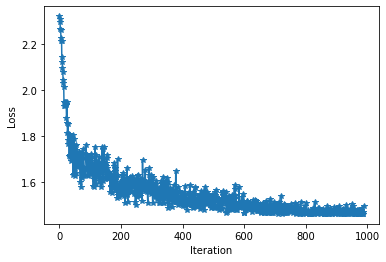

In [ ]:
criterion = nn.CrossEntropyLoss()
resnet_1_loss_arr,best_resnet_1 = train_batch(resnet_1,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_resnet_1,val_data,128,device_gpu)

0.9744525547445255

In [ ]:
calc_accuracy(best_resnet_1,plantdoc_val_data2,128,device_gpu) #with deformable accuracy

0.6474654937791602

In [ ]:
torch.save(best_resnet_1,"newdataset_deformable_resnet_1.1(97%,64%")

###DEF_RESNET CASE-2

In [ ]:
resnet_2 = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in resnet_2.parameters():
    param.requires_grad_(False)

In [ ]:
"""Unfreezing the conv3,bn3 adn relu layer of the third bottleneck of the layer4"""
count = 0
for param in resnet_2.layer4[2].parameters():
    if count>=3:
        param.requires_grad_(True)
    count+=1

In [ ]:
new_out_features = 10           #total number of dieseas for tomato in our dataset. Here we have 10 diseases in total
final_in_features = resnet_2.fc.in_features
resnet_2.fc = nn.Linear(final_in_features,new_out_features)

In [ ]:
resnet_2.layer4[1].conv1 = DeformConv2d(2048,512,1,1,bias=False)
resnet_2.layer4[1].conv2 = DeformConv2d(512,512,3,3,bias=False)
resnet_2.layer4[1].conv3 = DeformConv2d(512,2048,1,1,bias=False)
resnet_2.layer4[2].conv1 = DeformConv2d(2048,512,1,1,bias=False)
resnet_2.layer4[2].conv2 = DeformConv2d(512,512,3,3,bias=False)
resnet_2.layer4[2].conv3 = DeformConv2d(512,2048,1,1,bias=False)

In [ ]:
print(resnet_2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

TRAINING

Iteration 1290 Loss tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward>)


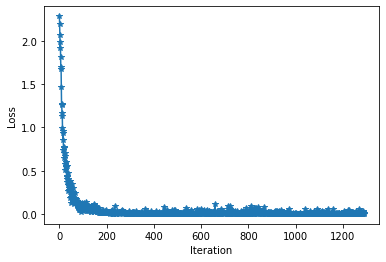

In [ ]:
criterion = nn.CrossEntropyLoss()
resnet_2_loss_arr,best_resnet_2 = train_batch(resnet_2,criterion,train_data,lr=0.0001,batch_size=128,epochs=1300,device=device_gpu)

In [ ]:
calc_accuracy(best_resnet_2,val_data,128,device_gpu)

0.982193772810219

In [ ]:
calc_accuracy(best_resnet_2,plantdoc_val_data2,128,device_gpu)

0.6049523716951789

In [ ]:
torch.save(best_resnet_2,"newdataset_deformable_resnet_2.1(98%,60%)")

###DEF_RESNET SCRATCH

In [ ]:
scratch_defresnet_newdataset = models.resnet50(pretrained=True)

In [ ]:
"""Freeze all the layers of the resnet"""
for param in scratch_defresnet_newdataset.parameters():
    param.requires_grad_(True)

In [ ]:
scratch_defresnet_newdataset.layer4[2].conv1 = DeformConv2d(2048,512,1,1,bias=False)
scratch_defresnet_newdataset.layer4[2].conv2 = DeformConv2d(512,512,3,3,bias=False)
scratch_defresnet_newdataset.layer4[2].conv3 = DeformConv2d(512,2048,1,1,bias=False)

TRAINING

Iteration 1490 Loss tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward>)


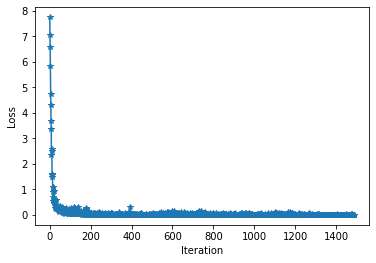

In [ ]:
criterion = nn.CrossEntropyLoss()
scratch_defresnet_loss_arr,scratch_defresnet_bm = train_batch(scratch_defresnet_newdataset,criterion,train_data,lr=0.0001,batch_size=64,epochs=1500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(scratch_defresnet_bm,val_data,128,device_gpu)

0.9940835994525548

In [ ]:
calc_accuracy(scratch_defresnet_bm,plantdoc_val_data2,128,device_gpu) #with deformable accuracy

0.6372229782270606

In [ ]:
torch.save(scratch_defresnet_bm,"scratch_def_resnet_newdataset(99%,63.7%)")

##Inception Resnet

###Inception Block Definition

In [ ]:
class inception_block_d(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block_d,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = DeformConv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            DeformConv2d(in_channels,512,1),
            DeformConv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            DeformConv2d(in_channels,512,1),
            DeformConv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            DeformConv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
class inception_block(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = nn.Conv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            nn.Conv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
# c_resnet = models.resnet50(pretrained=True)
# """Freeze all the layers of the resnet"""
# for param in c_resnet.parameters():
#     param.requires_grad_(True)

In [ ]:
# print(c_resnet.layer4)

In [ ]:
# c_resnet.layer4[0] = inception_block_d(1024,2048)
# c_resnet.layer4[1] = inception_block_d(2048,2048)
# c_resnet.layer4[2] = inception_block_d(2048,2048)
# c_resnet.fc = nn.Linear(2048,10)

In [ ]:
# print(c_resnet)

###DEF INC RESNET 

In [ ]:
def_inc_resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
i=1
for param in def_inc_resnet.parameters():
    i+=1
    if i<100:
        param.requires_grad_(False)
    else:
        param.requires_grad_(True)

In [ ]:
# summary(def_inc_resnet, (3,224,224),device="cpu")

In [ ]:
# def_inc_resnet.layer4[0] = inception_block_d(1024,2048)
def_inc_resnet.layer4[1] = inception_block_d(2048,2048)
# def_inc_resnet.layer4[2] = inception_block_d(2048,2048)
def_inc_resnet.fc = nn.Linear(2048,10)

In [ ]:
#summary(def_inc_resnet, (3,224,224),device="cpu")

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
torch.cuda.empty_cache()

Iteration 2790 Loss tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward>)


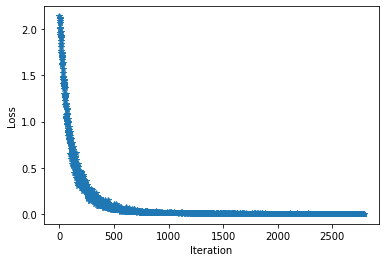

In [ ]:
new_l,new_bm = train_batch(def_inc_resnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=2800,display=True,device=device_gpu)

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data2,128,device_gpu)

0.6264944595645412

In [ ]:
calc_accuracy(new_bm,val_data,128,device_gpu)   

0.9844676665145985

In [ ]:
torch.save(new_bm,"def_inc_resnet3(62.6%)")

####OTHERS

In [ ]:
def_inc_resnet = models.resnet50(pretrained=True)

In [ ]:
i=1
for param in def_inc_resnet.parameters():
    i+=1
    if i<50:
        param.requires_grad_(False)
    else:
        param.requires_grad_(True)

In [ ]:
# summary(def_inc_resnet, (3,224,224),device="cpu")

In [ ]:
# def_inc_resnet.layer3[5] = inception_block_d(512,1024)
# def_inc_resnet.layer3[5] = inception_block_d(1024,1024)
# def_inc_resnet.layer4[0] = inception_block_d(1024,2048)
def_inc_resnet.layer4[1] = inception_block_d(2048,2048)
# def_inc_resnet.layer4[2] = inception_block_d(2048,2048)
def_inc_resnet.fc = nn.Linear(2048,10)

In [ ]:
#summary(def_inc_resnet, (3,224,224),device="cpu")

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
torch.cuda.empty_cache()

Iteration 2790 Loss tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)


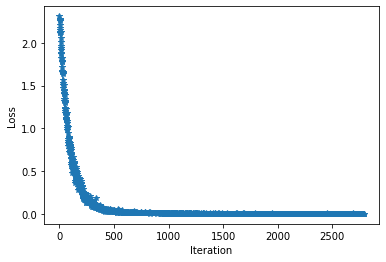

In [ ]:
new_l,new_bm = train_batch(def_inc_resnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=2800,display=True,device=device_gpu)

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data2,128,device_gpu)

0.6459102838258165

In [ ]:
calc_accuracy(new_bm,val_data,128,device_gpu)   

0.989040402600365

In [ ]:
torch.save(new_bm,"def_inc_resnet5(64.59%)")

In [ ]:
def_inc_resnet = models.resnet50(pretrained=True)

In [ ]:
i=1
for param in def_inc_resnet.parameters():
    i+=1
    if i<75:
        param.requires_grad_(False)
    else:
        param.requires_grad_(True)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
torch.cuda.empty_cache()

Iteration 2790 Loss tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)


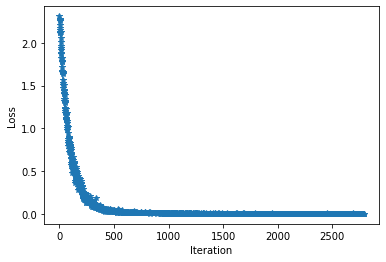

In [ ]:
new_l,new_bm = train_batch(def_inc_resnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=2800,display=True,device=device_gpu)

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data2,128,device_gpu)

0.6474654937791602

In [ ]:
calc_accuracy(new_bm,val_data,128,device_gpu)   

0.9862996122262774

In [ ]:
torch.save(new_bm,"def_inc_resnet4(64.7%)")

####EXTRAS

Iteration 3990 Loss tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward>)


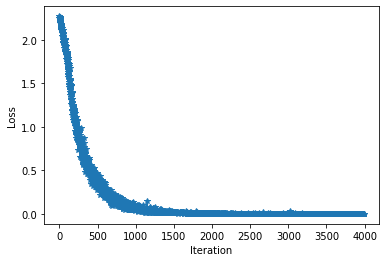

In [ ]:
new_l,new_bm = train_batch(def_inc_resnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=4000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data2,128,device_gpu)

0.583471034214619

In [ ]:
torch.save(new_bm,"def_inc_resnet2(58.3%)")

Iteration 1130 Loss tensor(0.5826, grad_fn=<NllLossBackward>)


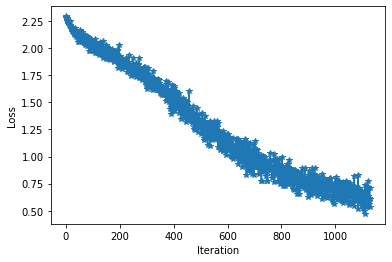

In [ ]:
new_l,new_bm = train_batch(def_inc_resnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=1500,display=True,device='cpu')

###DEF INCEPTION RESNET SCRATCH

In [ ]:
scratch_def_resnet = models.resnet50(pretrained=True)

In [ ]:
i=1
for param in scratch_def_resnet.parameters():
    if i<100:
        param.requires_grad_(False)
    else:
        param.requires_grad_(True)
    i+=1

In [ ]:
scratch_def_resnet.conv1 = DeformConv2d(3,64,7,3,2,False)

# scratch_def_resnet.layer1[0].conv1 = DeformConv2d(64,64,1,1,1,False)
scratch_def_resnet.layer1[0].conv2 = DeformConv2d(64,64,3,1,1,False)
scratch_def_resnet.layer1[0].conv3 = DeformConv2d(64,256,1,1,1,False)
# scratch_def_resnet.layer1[0].downsample[0] = DeformConv2d(64,256,1,1,1,False)

scratch_def_resnet.layer1[1].conv1 = DeformConv2d(256,64,1,1,1,False)
scratch_def_resnet.layer1[1].conv2 = DeformConv2d(64,64,3,1,1,False)
scratch_def_resnet.layer1[1].conv3 = DeformConv2d(64,256,1,1,1,False)

scratch_def_resnet.layer1[2].conv1 = DeformConv2d(256,64,1,1,1,False)
scratch_def_resnet.layer1[2].conv2 = DeformConv2d(64,64,3,1,1,False)
scratch_def_resnet.layer1[2].conv3 = DeformConv2d(64,256,1,1,1,False)

# scratch_def_resnet.layer2[0].conv1 = DeformConv2d(256,128,1,1,1,False)
# scratch_def_resnet.layer2[0].conv2 = DeformConv2d(128,128,3,1,2,False)
# scratch_def_resnet.layer2[0].conv3 = DeformConv2d(128,512,1,1,1,False)
# scratch_def_resnet.layer2[0].downsample[0] = DeformConv2d(256,512,1,1,1,False)

# scratch_def_resnet.layer2[1].conv1 = DeformConv2d(512,128,1,1,1,False)
# scratch_def_resnet.layer2[1].conv2 = DeformConv2d(128,128,3,1,1,False)
# scratch_def_resnet.layer2[1].conv3 = DeformConv2d(128,512,1,1,1,False)

# scratch_def_resnet.layer2[2].conv1 = DeformConv2d(512,128,1,1,1,False)
# scratch_def_resnet.layer2[2].conv2 = DeformConv2d(128,128,3,1,1,False)
# scratch_def_resnet.layer2[2].conv3 = DeformConv2d(128,512,1,1,1,False)

# scratch_def_resnet.layer2[3].conv1 = DeformConv2d(512,128,1,1,1,False)
# scratch_def_resnet.layer2[3].conv2 = DeformConv2d(128,128,3,1,1,False)
# scratch_def_resnet.layer2[3].conv3 = DeformConv2d(128,512,1,1,1,False)

# scratch_def_resnet.layer3[0].conv1 = DeformConv2d(512,256,1,1,1,False)
# scratch_def_resnet.layer3[0].conv2 = DeformConv2d(256,256,3,1,2,False)
# scratch_def_resnet.layer3[0].conv3 = DeformConv2d(256,1024,1,1,1,False)
# scratch_def_resnet.layer3[0].downsample[0] = DeformConv2d(256,512,1,1,1,False)

# scratch_def_resnet.layer3[1].conv1 = DeformConv2d(1024,256,1,1,1,False)
# scratch_def_resnet.layer3[1].conv2 = DeformConv2d(256,256,3,1,1,False)
# scratch_def_resnet.layer3[1].conv3 = DeformConv2d(256,1024,1,1,1,False)

# scratch_def_resnet.layer3[2].conv1 = DeformConv2d(1024,256,1,1,1,False)
# scratch_def_resnet.layer3[2].conv2 = DeformConv2d(256,256,3,1,1,False)
# scratch_def_resnet.layer3[2].conv3 = DeformConv2d(256,1024,1,1,1,False)

# scratch_def_resnet.layer3[3].conv1 = DeformConv2d(1024,256,1,1,1,False)
# scratch_def_resnet.layer3[3].conv2 = DeformConv2d(256,256,3,1,1,False)
# scratch_def_resnet.layer3[3].conv3 = DeformConv2d(256,1024,1,1,1,False)

# scratch_def_resnet.layer3[4].conv1 = DeformConv2d(1024,256,1,1,1,False)
# scratch_def_resnet.layer3[4].conv2 = DeformConv2d(256,256,3,1,1,False)
# scratch_def_resnet.layer3[4].conv3 = DeformConv2d(256,1024,1,1,1,False)

# scratch_def_resnet.layer3[5].conv1 = DeformConv2d(1024,256,1,1,1,False)
# scratch_def_resnet.layer3[5].conv2 = DeformConv2d(256,256,3,1,1,False)
# scratch_def_resnet.layer3[5].conv3 = DeformConv2d(256,1024,1,1,1,False)

# scratch_def_resnet.layer4[0].conv1 = DeformConv2d(1024,512,1,1,1,False)
# scratch_def_resnet.layer4[0].conv2 = DeformConv2d(512,512,3,1,2,False)
# scratch_def_resnet.layer4[0].conv3 = DeformConv2d(512,2048,1,1,1,False)
# scratch_def_resnet.layer4[0].downsample[0] = DeformConv2d(1024,2048,1,1,2,False)

# scratch_def_resnet.layer4[1].conv1 = DeformConv2d(2048,512,1,1,1,False)
# scratch_def_resnet.layer4[1].conv2 = DeformConv2d(512,512,3,1,1,False)
# scratch_def_resnet.layer4[1].conv3 = DeformConv2d(512,2048,1,1,1,False)

# scratch_def_resnet.layer4[2].conv1 = DeformConv2d(2048,512,1,1,1,False)
# scratch_def_resnet.layer4[2].conv2 = DeformConv2d(512,512,3,1,1,False)
# scratch_def_resnet.layer4[2].conv3 = DeformConv2d(512,2048,1,1,1,False)


In [ ]:
# scratch_def_resnet.layer4[0] = inception_block_d(1024,2048)
scratch_def_resnet.layer4[1] = inception_block_d(2048,2048)
# scratch_def_resnet.layer4[2] = inception_block_d(2048,2048)
scratch_def_resnet.fc = nn.Linear(2048,10)

In [ ]:
#  summary(scratch_def_resnet, (3,224,224),device="cpu")

In [ ]:
# summary(scratch_def_resnet, (3,224,224),device='cpu')       #4,34,88,450

In [ ]:
# summary(scratch_def_resnet, (3,224,224),device='cpu')       #4,34,88,450

In [ ]:
torch.cuda.empty_cache()

In [ ]:
scratch_new_l,scratch_new_bm = train_batch(scratch_def_resnet,criterion,train_data,lr=0.00001,batch_size=128,epochs=20,display=True,device=device_gpu)

In [ ]:
# i=0
# """Freeze all the layers of the resnet"""
# for param in scratch_def_resnet.parameters():
#     if i<0:
#         param.requires_grad_(False)
#     else:
#         param.requires_grad_(True)
#     i+=1

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
calc_accuracy(scratch_new_bm,val_data,128,device_gpu)

0.9466846772354015

In [ ]:
calc_accuracy(scratch_new_bm,plantdoc_val_data2,128,device_gpu)

0.49193234836702954

In [ ]:
# for child in scratch_def_resnet.named_children():
#     if isinstance(child[1], nn.Conv2d):
#         in_c = child[1].in_channels
#         out_c = child[1].out_channels
#         ker_size = child[1].kernel_size
#         stride = child[1].stride
#         pad = child[1].padding
#         bias = child[1].bias
#         name = child[0]
#         scratch_def_resnet2.name = DeformConv2d(in_c,out_c,ker_size[0],pad,stride,bias)
#     if isinstance(child[1], nn.Sequential):
#         bottleneck_no=-1
#         for bottleneck in child[1]: 
#             bottleneck_no+=1
#             for lay in bottleneck.named_children():
#                 if isinstance(lay[1], nn.Conv2d):
#                      in_c = lay[1].in_channels
#                      out_c = lay[1].out_channels
#                      ker_size = lay[1].kernel_size
#                      stride = lay[1].stride
#                      pad = lay[1].padding
#                      bias = lay[1].bias
#                      name = child[0][bottleneck_no]
#                      lay_name = lay[0]
#                      scratch_def_resnet2.name.lay_name = DeformConv2d(in_c,out_c,ker_size[0],pad,stride,bias)

###Inception Resnet Training Process

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
new_l,new_bm = train_batch(c_resnet,criterion,train_data,lr=0.00001,batch_size=64,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(new_bm,val_data,64,device_gpu)

0.9588917084854015

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data,64,device_gpu)

0.5200674019607843

In [ ]:
torch.save(new_bm,"newdataset_model_1.1")

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data2,64,device_gpu)

0.5231337480559876

In [ ]:
newdataset_path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code/NewDataset Models/newdataset_model_1.1"
new_model = torch.load(newdataset_path_load)

Iteration 190 Loss tensor(0.1042, device='cuda:0', grad_fn=<NllLossBackward>)


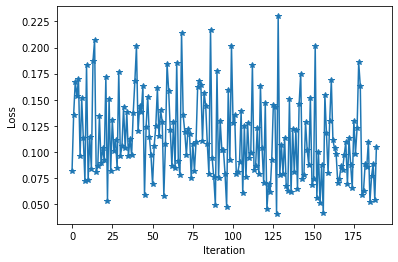




Min loss model saved with LOSS=  tensor(0.0405, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
new_l,new_bm = train_batch(new_model,criterion,train_data,lr=0.000001,batch_size=128,epochs=200,display=True,device=device_gpu)

In [ ]:
calc_accuracy(new_bm,plantdoc_val_data2,64,device_gpu)

0.5331211119751167

In [ ]:
#torch.save(new_bm,"newdataset_1.2")

In [ ]:
newdataset_path_load = f"drive/My Drive/Aditya Arnav-CropDisease/Code/NewDataset Models/newdataset_model_1.2"
new_model = torch.load(newdataset_path_load)

In [ ]:
new_l2,new_bm2 = train_batch(new_model,criterion,train_data,lr=0.0000001,batch_size=128,epochs=200,display=True,device=device_gpu)

In [ ]:
calc_accuracy(new_model,plantdoc_val_data2,128,device_gpu)

In [ ]:
print(1)

1


#**BENCHMARK RESULTS**


##**AlexNet**

###PlantVillage

####Model Definition

In [ ]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
in_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(in_features,new_out_features)

####Training

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(image_dict_saved["TOMATO"],
                                               label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=label_dict_saved["TOMATO"],
                                               random_state=0)

Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
train_img_dict = {}
val_img_dict={}
train_label_dict={}
val_label_dict={}
train_img_dict["TOMATO"] = X_train
val_img_dict["TOMATO"] = X_val
train_label_dict["TOMATO"] = Y_L_train
val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,train_img_dict,train_label_dict)
val_data = PlantImageDataloader(path,image_transform,val_img_dict,val_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 990 Loss tensor(0.0311, device='cuda:0', grad_fn=<NllLossBackward>)


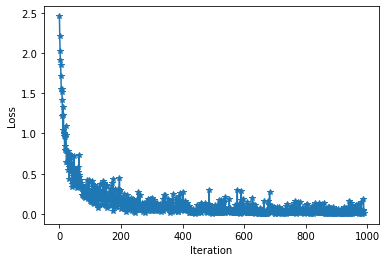

In [ ]:
alexnet_loss_arr,best_alexnet = train_batch(alexnet,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_alexnet,val_data,128,device=device_gpu)

0.9837407629059117

In [ ]:
calc_accuracy(best_alexnet,val_data,128,device=device_gpu)

0.9837928028726062

In [ ]:
torch.save(best_alexnet,"plantvillage_benchmark_alexnet1.1(98%)")

###PlantDoc

####Model Definition

In [ ]:
alexnet_plantdoc = models.alexnet(pretrained=True)

In [ ]:
print(alexnet_plantdoc)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
in_features = alexnet_plantdoc.classifier[6].in_features
alexnet_plantdoc.classifier[6] = nn.Linear(in_features,new_out_features)

####Training

In [ ]:
X_train_plantdoc,X_val_plantdoc,Y_train_plantdoc,Y_val_plantdoc = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc = le.transform(Y_train_plantdoc)
Y_L_val_plantdoc = le.transform(Y_val_plantdoc)

In [ ]:
plantdoc_train_img_dict = {}
plantdoc_val_img_dict={}
plantdoc_train_label_dict={}
plantdoc_val_label_dict={}
plantdoc_train_img_dict["TOMATO"] = X_train_plantdoc
plantdoc_val_img_dict["TOMATO"] = X_val_plantdoc
plantdoc_train_label_dict["TOMATO"] = Y_L_train_plantdoc
plantdoc_val_label_dict["TOMATO"] = Y_L_val_plantdoc

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict,plantdoc_train_label_dict)
plantdoc_val_data = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict,plantdoc_val_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 990 Loss tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward>)


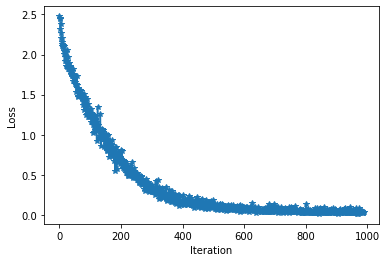

In [ ]:
l_alexnet,bm_alexnet = train_batch(alexnet_plantdoc,criterion,plantdoc_train_data,lr=0.00001,batch_size=128,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_alexnet,plantdoc_val_data,128,device=device_gpu)

0.5086550245098039

In [ ]:
torch.save(bm_alexnet,"plantdoc_benchmark_alexnet1.1(50%)")

###New Image Dataset

####Model Definition

In [ ]:
alexnet_newdataset = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
print(alexnet_newdataset)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
in_features = alexnet_newdataset.classifier[6].in_features
alexnet_newdataset.classifier[6] = nn.Linear(in_features,new_out_features)

####Training

In [ ]:
X_train_plantdoc2,X_val_plantdoc2,Y_train_plantdoc2,Y_val_plantdoc2 = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.95,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc2 = le.transform(Y_train_plantdoc2)
Y_L_val_plantdoc2 = le.transform(Y_val_plantdoc2)

In [ ]:
plantdoc_train_img_dict2 = {}
plantdoc_val_img_dict2={}
plantdoc_train_label_dict2={}
plantdoc_val_label_dict2={}
plantdoc_train_img_dict2["TOMATO"] = X_train_plantdoc2
plantdoc_val_img_dict2["TOMATO"] = X_val_plantdoc2
plantdoc_train_label_dict2["TOMATO"] = Y_L_train_plantdoc2
plantdoc_val_label_dict2["TOMATO"] = Y_L_val_plantdoc2

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data2 = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict2,plantdoc_train_label_dict2)
plantdoc_val_data2 = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict2,plantdoc_val_label_dict2)

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(new_dataset_imgs["TOMATO"],
                                               new_dataset_labels["TOMATO"],
                                               test_size=0.15,
                                               stratify=new_dataset_labels["TOMATO"],
                                               random_state=0)

Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
new_dataset_train_img_dict = {}
new_dataset_val_img_dict={}
new_dataset_train_label_dict={}
new_dataset_val_label_dict={}
new_dataset_train_img_dict["TOMATO"] = X_train
new_dataset_val_img_dict["TOMATO"] = X_val
new_dataset_train_label_dict["TOMATO"] = Y_L_train
new_dataset_val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,new_dataset_train_img_dict,new_dataset_train_label_dict)
val_data = PlantImageDataloader(path,image_transform,new_dataset_val_img_dict,new_dataset_val_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 1990 Loss tensor(0.0104, device='cuda:0', grad_fn=<NllLossBackward>)


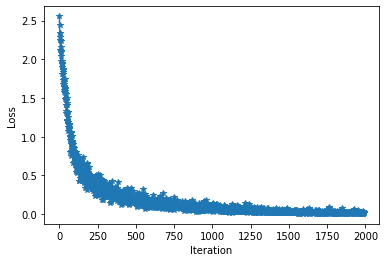

In [ ]:
l_alexnet,bm_alexnet = train_batch(alexnet_newdataset,criterion,train_data,lr=0.00001,batch_size=128,epochs=2000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_alexnet,val_data,128,device=device_gpu)

0.9652928261861314

In [ ]:
calc_accuracy(bm_alexnet,plantdoc_val_data2,128,device=device_gpu)

0.5041917768273717

In [ ]:
torch.save(bm_alexnet,"newdataset_benchmark_alexnet1.1(96.5%,50%)")

##**VGG NET**

###PlantVillage

####Model Definition

In [ ]:
vgg = models.vgg13(pretrained=True)

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

In [ ]:
for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
in_features6 = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(in_features6,new_out_features)
# vgg.classifier[6] = nn.Sequential(
#                  nn.Linear(in_features6,new_out_features),
#                  nn.Softmax())
# in_features3 = vgg.classifier[3].in_features
# out_features3 = vgg.classifier[3].out_features
# vgg.classifier[3] = nn.Linear(in_features3,out_features3)

# in_features0 = vgg.classifier[0].in_features
# out_features0 = vgg.classifier[0].out_features
# vgg.classifier[0] = nn.Linear(in_features0,out_features0)

####Training

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(image_dict_saved["TOMATO"],
                                               label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=label_dict_saved["TOMATO"],
                                               random_state=0)

Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
train_img_dict = {}
val_img_dict={}
train_label_dict={}
val_label_dict={}
train_img_dict["TOMATO"] = X_train
val_img_dict["TOMATO"] = X_val
train_label_dict["TOMATO"] = Y_L_train
val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,train_img_dict,train_label_dict)
val_data = PlantImageDataloader(path,image_transform,val_img_dict,val_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 990 Loss tensor(0.8310, device='cuda:0', grad_fn=<NllLossBackward>)


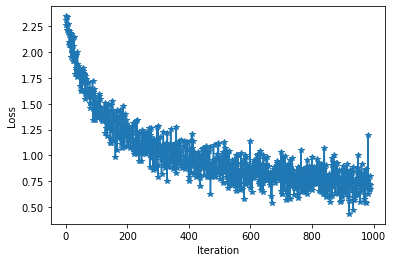

In [ ]:
vgg_loss_arr,best_vgg = train_batch(vgg,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_vgg,val_data,128,device=device_gpu)

0.8003486677768527

In [ ]:
torch.save(best_vgg,"plantvillage_benchmark_vgg1.1(80%)")

###PlantDoc

####Model Definition

In [ ]:
vgg_plantdoc = models.vgg13(pretrained=True)

In [ ]:
for param in vgg_plantdoc.parameters():
    param.requires_grad_(False)

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
in_features6 = vgg_plantdoc.classifier[6].in_features
vgg_plantdoc.classifier[6] = nn.Linear(in_features6,new_out_features)
# vgg_plantdoc.classifier[6] = nn.Sequential(
#                  nn.Linear(in_features6,new_out_features),
#                  nn.Softmax())
# in_features3 = vgg_plantdoc.classifier[3].in_features
# out_features3 = vgg_plantdoc.classifier[3].out_features
# vgg_plantdoc.classifier[3] = nn.Linear(in_features3,out_features3)

# in_features0 = vgg_plantdoc.classifier[0].in_features
# out_features0 = vgg_plantdoc.classifier[0].out_features
# vgg_plantdoc.classifier[0] = nn.Linear(in_features0,out_features0)

####Training

In [ ]:
X_train_plantdoc,X_val_plantdoc,Y_train_plantdoc,Y_val_plantdoc = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc = le.transform(Y_train_plantdoc)
Y_L_val_plantdoc = le.transform(Y_val_plantdoc)

In [ ]:
plantdoc_train_img_dict = {}
plantdoc_val_img_dict={}
plantdoc_train_label_dict={}
plantdoc_val_label_dict={}
plantdoc_train_img_dict["TOMATO"] = X_train_plantdoc
plantdoc_val_img_dict["TOMATO"] = X_val_plantdoc
plantdoc_train_label_dict["TOMATO"] = Y_L_train_plantdoc
plantdoc_val_label_dict["TOMATO"] = Y_L_val_plantdoc

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict,plantdoc_train_label_dict)
plantdoc_val_data = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict,plantdoc_val_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 990 Loss tensor(1.6951, device='cuda:0', grad_fn=<NllLossBackward>)


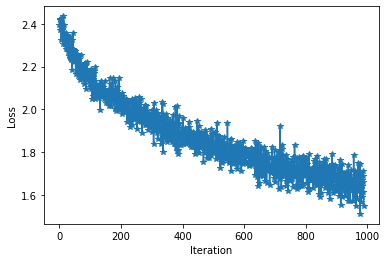

In [ ]:
l_vgg,bm_vgg = train_batch(vgg_plantdoc,criterion,plantdoc_train_data,lr=0.00001,batch_size=128,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_vgg,plantdoc_val_data,128,device=device_gpu)

0.4135263480392157

In [ ]:
torch.save(bm_vgg,"plantdoc_benchmark_vgg1.1(41.3%)")

###New Image Dataset

####Model Definition

In [ ]:
vgg_newdataset = models.vgg13(pretrained=True)

In [ ]:
for param in vgg_newdataset.parameters():
    param.requires_grad_(False)

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
in_features6 = vgg_newdataset.classifier[6].in_features
vgg_newdataset.classifier[6] = nn.Linear(in_features6,new_out_features)
# vgg_newdataset.classifier[6] = nn.Sequential(
#                  nn.Linear(in_features6,new_out_features),
#                  nn.Softmax())
# in_features3 = vgg_newdataset.classifier[3].in_features
# out_features3 = vgg_newdataset.classifier[3].out_features
# vgg_newdataset.classifier[3] = nn.Linear(in_features3,out_features3)

# in_features0 = vgg_newdataset.classifier[0].in_features
# out_features0 = vgg_newdataset.classifier[0].out_features
# vgg_newdataset.classifier[0] = nn.Linear(in_features0,out_features0)

####Training

In [ ]:
X_train_plantdoc2,X_val_plantdoc2,Y_train_plantdoc2,Y_val_plantdoc2 = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.95,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc2 = le.transform(Y_train_plantdoc2)
Y_L_val_plantdoc2 = le.transform(Y_val_plantdoc2)

In [ ]:
plantdoc_train_img_dict2 = {}
plantdoc_val_img_dict2={}
plantdoc_train_label_dict2={}
plantdoc_val_label_dict2={}
plantdoc_train_img_dict2["TOMATO"] = X_train_plantdoc2
plantdoc_val_img_dict2["TOMATO"] = X_val_plantdoc2
plantdoc_train_label_dict2["TOMATO"] = Y_L_train_plantdoc2
plantdoc_val_label_dict2["TOMATO"] = Y_L_val_plantdoc2

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data2 = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict2,plantdoc_train_label_dict2)
plantdoc_val_data2 = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict2,plantdoc_val_label_dict2)

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(new_dataset_imgs["TOMATO"],
                                               new_dataset_labels["TOMATO"],
                                               test_size=0.15,
                                               stratify=new_dataset_labels["TOMATO"],
                                               random_state=0)

Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
new_dataset_train_img_dict = {}
new_dataset_val_img_dict={}
new_dataset_train_label_dict={}
new_dataset_val_label_dict={}
new_dataset_train_img_dict["TOMATO"] = X_train
new_dataset_val_img_dict["TOMATO"] = X_val
new_dataset_train_label_dict["TOMATO"] = Y_L_train
new_dataset_val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,new_dataset_train_img_dict,new_dataset_train_label_dict)
val_data = PlantImageDataloader(path,image_transform,new_dataset_val_img_dict,new_dataset_val_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 1990 Loss tensor(1.1554, device='cuda:0', grad_fn=<NllLossBackward>)


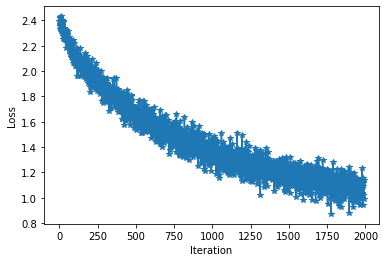

In [ ]:
l_vgg,bm_vgg = train_batch(vgg_newdataset,criterion,train_data,lr=0.00001,batch_size=128,epochs=2000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_vgg,val_data,128,device=device_gpu)

0.7376646612682481

In [ ]:
calc_accuracy(bm_vgg,plantdoc_val_data2,128,device=device_gpu)

0.28148085147744945

In [ ]:
torch.save(bm_vgg,"newdataset_benchmark_vgg1.1(74%,28%)")

##**XCEPTION NET**

###Model Code

In [ ]:
import torch.utils.model_zoo as model_zoo
from torch.nn import init

__all__ = ['xception']

model_urls = {
    'xception':'https://www.dropbox.com/s/1hplpzet9d7dv29/xception-c0a72b38.pth.tar?dl=1'
}


class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x



class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)



        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------





    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



def xception(pretrained=False,**kwargs):
    """
    Construct Xception.
    """

    model = Xception(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['xception']))
    return model

###PlantVillage

####Model Definition

In [ ]:
xception = xception(pretrained=True)

In [ ]:
print(xception)

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [ ]:
for param in xception.parameters():
    param.requires_grad_(False)

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
in_features = xception.fc.in_features
xception.fc = nn.Sequential(
                   nn.Linear(in_features,new_out_features),
                   nn.Softmax())


In [ ]:
for param in xception.block12.parameters():
    param.requires_grad_(True)
for param in xception.conv3.parameters():
    param.requires_grad_(True)
for param in xception.conv4.parameters():
    param.requires_grad_(True)

In [ ]:
summary(xception,(3,224,224),device="cpu")      #trainable parameters are 68,01,706

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]          18,432
       BatchNorm2d-5         [-1, 64, 109, 109]             128
              ReLU-6         [-1, 64, 109, 109]               0
            Conv2d-7         [-1, 64, 109, 109]             576
            Conv2d-8        [-1, 128, 109, 109]           8,192
   SeparableConv2d-9        [-1, 128, 109, 109]               0
      BatchNorm2d-10        [-1, 128, 109, 109]             256
             ReLU-11        [-1, 128, 109, 109]               0
             ReLU-12        [-1, 128, 109, 109]               0
           Conv2d-13        [-1, 128, 109, 109]           1,152
           Conv2d-14        [-1, 128, 1

####Training

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(image_dict_saved["TOMATO"],
                                               label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=label_dict_saved["TOMATO"],
                                               random_state=0)

Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
train_img_dict = {}
val_img_dict={}
train_label_dict={}
val_label_dict={}
train_img_dict["TOMATO"] = X_train
val_img_dict["TOMATO"] = X_val
train_label_dict["TOMATO"] = Y_L_train
val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,train_img_dict,train_label_dict)
val_data = PlantImageDataloader(path,image_transform,val_img_dict,val_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 990 Loss tensor(1.4665, device='cuda:0', grad_fn=<NllLossBackward>)


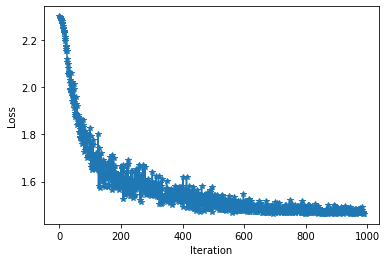

In [ ]:
xception_loss_arr,best_xception = train_batch(xception,criterion,train_data,lr=0.0001,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_xception,val_data,128,device=device_gpu)

0.9809045847210658

In [ ]:
torch.save(best_xception,"plantvillage_benchmark_xception1.1(98%)")

###PlantDoc

####Model Definition

In [ ]:
xception_plantdoc = xception(pretrained=True)

Downloading: "https://www.dropbox.com/s/1hplpzet9d7dv29/xception-c0a72b38.pth.tar?dl=1" to /root/.cache/torch/hub/checkpoints/xception-c0a72b38.pth.tar


In [ ]:
for param in xception_plantdoc.parameters():
    param.requires_grad_(False)

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
in_features = xception_plantdoc.fc.in_features
xception_plantdoc.fc = nn.Sequential(
                   nn.Linear(in_features,new_out_features),
                   nn.Softmax())

In [ ]:
for param in xception_plantdoc.block12.parameters():
    param.requires_grad_(True)
for param in xception_plantdoc.conv3.parameters():
    param.requires_grad_(True)
for param in xception_plantdoc.conv4.parameters():
    param.requires_grad_(True)

In [ ]:
summary(xception_plantdoc,(3,224,224),device="cpu")      #trainable parameters are 68,01,706

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]          18,432
       BatchNorm2d-5         [-1, 64, 109, 109]             128
              ReLU-6         [-1, 64, 109, 109]               0
            Conv2d-7         [-1, 64, 109, 109]             576
            Conv2d-8        [-1, 128, 109, 109]           8,192
   SeparableConv2d-9        [-1, 128, 109, 109]               0
      BatchNorm2d-10        [-1, 128, 109, 109]             256
             ReLU-11        [-1, 128, 109, 109]               0
             ReLU-12        [-1, 128, 109, 109]               0
           Conv2d-13        [-1, 128, 109, 109]           1,152
           Conv2d-14        [-1, 128, 1

####Training

In [ ]:
X_train_plantdoc,X_val_plantdoc,Y_train_plantdoc,Y_val_plantdoc = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc = le.transform(Y_train_plantdoc)
Y_L_val_plantdoc = le.transform(Y_val_plantdoc)

In [ ]:
plantdoc_train_img_dict = {}
plantdoc_val_img_dict={}
plantdoc_train_label_dict={}
plantdoc_val_label_dict={}
plantdoc_train_img_dict["TOMATO"] = X_train_plantdoc
plantdoc_val_img_dict["TOMATO"] = X_val_plantdoc
plantdoc_train_label_dict["TOMATO"] = Y_L_train_plantdoc
plantdoc_val_label_dict["TOMATO"] = Y_L_val_plantdoc

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict,plantdoc_train_label_dict)
plantdoc_val_data = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict,plantdoc_val_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 990 Loss tensor(1.4656, device='cuda:0', grad_fn=<NllLossBackward>)


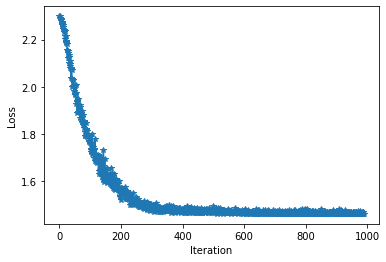

In [ ]:
l_xception,bm_xception = train_batch(xception_plantdoc,criterion,plantdoc_train_data,lr=0.0001,batch_size=128,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_xception,plantdoc_val_data,128,device=device_gpu)

0.4775582107843137

In [ ]:
torch.save(bm_xception,"plantdoc_benchmark_xception1.1(48%)")

###New Image Dataset

####Model Definition

In [ ]:
xception_newdataset = xception(pretrained=True)

Downloading: "https://www.dropbox.com/s/1hplpzet9d7dv29/xception-c0a72b38.pth.tar?dl=1" to /root/.cache/torch/hub/checkpoints/xception-c0a72b38.pth.tar


In [ ]:
for param in xception_newdataset.parameters():
    param.requires_grad_(False)

In [ ]:
new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
in_features = xception_newdataset.fc.in_features
xception_newdataset.fc = nn.Sequential(
                   nn.Linear(in_features,new_out_features),
                   nn.Softmax())

In [ ]:
for param in xception_newdataset.block12.parameters():
    param.requires_grad_(True)
for param in xception_newdataset.conv3.parameters():
    param.requires_grad_(True)
for param in xception_newdataset.conv4.parameters():
    param.requires_grad_(True)

In [ ]:
summary(xception_newdataset,(3,224,224),device="cpu")      #trainable parameters are 68,01,706

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]          18,432
       BatchNorm2d-5         [-1, 64, 109, 109]             128
              ReLU-6         [-1, 64, 109, 109]               0
            Conv2d-7         [-1, 64, 109, 109]             576
            Conv2d-8        [-1, 128, 109, 109]           8,192
   SeparableConv2d-9        [-1, 128, 109, 109]               0
      BatchNorm2d-10        [-1, 128, 109, 109]             256
             ReLU-11        [-1, 128, 109, 109]               0
             ReLU-12        [-1, 128, 109, 109]               0
           Conv2d-13        [-1, 128, 109, 109]           1,152
           Conv2d-14        [-1, 128, 1

####Training

In [ ]:
X_train_plantdoc2,X_val_plantdoc2,Y_train_plantdoc2,Y_val_plantdoc2 = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.95,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc2 = le.transform(Y_train_plantdoc2)
Y_L_val_plantdoc2 = le.transform(Y_val_plantdoc2)

In [ ]:
plantdoc_train_img_dict2 = {}
plantdoc_val_img_dict2={}
plantdoc_train_label_dict2={}
plantdoc_val_label_dict2={}
plantdoc_train_img_dict2["TOMATO"] = X_train_plantdoc2
plantdoc_val_img_dict2["TOMATO"] = X_val_plantdoc2
plantdoc_train_label_dict2["TOMATO"] = Y_L_train_plantdoc2
plantdoc_val_label_dict2["TOMATO"] = Y_L_val_plantdoc2

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data2 = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict2,plantdoc_train_label_dict2)
plantdoc_val_data2 = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict2,plantdoc_val_label_dict2)

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(new_dataset_imgs["TOMATO"],
                                               new_dataset_labels["TOMATO"],
                                               test_size=0.15,
                                               stratify=new_dataset_labels["TOMATO"],
                                               random_state=0)

Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
new_dataset_train_img_dict = {}
new_dataset_val_img_dict={}
new_dataset_train_label_dict={}
new_dataset_val_label_dict={}
new_dataset_train_img_dict["TOMATO"] = X_train
new_dataset_val_img_dict["TOMATO"] = X_val
new_dataset_train_label_dict["TOMATO"] = Y_L_train
new_dataset_val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,new_dataset_train_img_dict,new_dataset_train_label_dict)
val_data = PlantImageDataloader(path,image_transform,new_dataset_val_img_dict,new_dataset_val_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()

Iteration 1490 Loss tensor(1.6792, device='cuda:0', grad_fn=<NllLossBackward>)


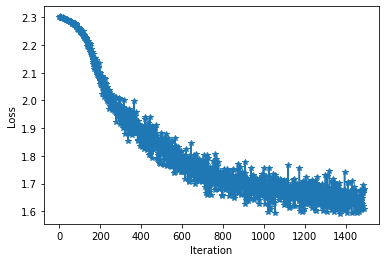

In [ ]:
l_xception,bm_xception = train_batch(xception_newdataset,criterion,train_data,lr=0.00001,batch_size=128,epochs=1500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_xception,val_data,128,device=device_gpu)

0.841754105839416

In [ ]:
calc_accuracy(bm_xception,plantdoc_val_data2,128,device=device_gpu)

0.46006269440124414

In [ ]:
torch.save(bm_xception,"newdataset_benchmark_xception1.1(84%,46%)")

#**EXTRAS**

##TRAINING FUNCTIONS

In [ ]:
def train_batch(net,criterion,data,lr=0.0001,batch_size=128,epochs=1000,plant_name="TOMATO",display=True,device='cpu'):
    min_loss = 1000
    loss_arr=[]
    opt = optim.Adam(net.parameters(),lr=lr)

    for i in range(epochs):
        net.train().to(device)
        opt.zero_grad()
        img_batch,label_batch = data.get_batch(batch_size,plant_name,1)
        img_batch,label_batch = img_batch.to(device),label_batch.to(device)    

        output = net(img_batch)
        loss = criterion(output,label_batch.long())

        loss.backward()
        opt.step()
        if loss<min_loss:
            best_model = net
            min_loss=loss
            print("Min loss model saved with LOSS= ",min_loss)

        loss_arr.append(loss)
        if display and (i%10==0):

            clear_output(wait=True)
            print('Iteration',i,'Loss',loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[0:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
    
    return loss_arr,best_model

In [ ]:
def infer(net,inputs,le=None,original=False,device="cpu"):
    net.to(device)
    pred_outputs = net(inputs)

    pred_output_labels = torch.argmax(pred_outputs,1)
    # if original:
    #     pred_output_labels = le.inverse_transform(pred_output_labels.to("cpu").numpy())
    
    return [pred_output_labels[i].item() for i in range(len(pred_output_labels))]

In [ ]:
def calc_accuracy(net,test_data,batch_size=128,device='cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(test_data.n["TOMATO"]):          #tr_epochs
        images,labels = test_data.get_batch(batch_size,flag=1)
        images,labels = images.to(device), labels.to(device)
        outputs = infer(net,images,device=device)
        correct = 0
        for index,out in enumerate(outputs):
            if out == labels[index]:
                correct+=1

        accuracy+=correct/len(outputs)

    accuracy/=len(test_data)
    return accuracy

In [ ]:
def predict(net,data,batch_size=1,plant_name="TOMATO",device="cpu"):
    img,label = data.get_batch(batch_size,"TOMATO",1)
    img = img.to(device)
    max_val,pred_label = torch.max(net(img),1)
    pred_label = le.inverse_transform(pred_label.to("cpu").numpy())
    true_label = le.inverse_transform(np.array(label,dtype=np.int))
    d = {"TRUE LABEL":true_label,"PREDICTED LABEL":pred_label}
    df = pd.DataFrame(d)
    print(tabulate(df, headers='keys', tablefmt='psql'))
    #print("The true class is",)
    #print("The predicted class is",pred_label)

##SECTION

In [ ]:
class PlantImageDataloader2(Dataset):

    def __init__(self,filename,transform,images_dict=None,labels_dict=None): 
        if (images_dict is None) or (labels_dict is None):
            self.images_dict,self.labels_dict = self.read_dataset(filename,transform)   #a dictionary containing image all the images with key=crop name
        else:
            self.images_dict = images_dict                                              #the values are of the form [image,disease] 
            self.labels_dict = labels_dict
        self.n = self.len_dict(self.images_dict)                                        #number of datapoints for each plant

        self.shuffle_indices,self.shuffle_start_index = self.get_shuffled_indices(self.n)   #indices shuffled to get a random sample
        
        
    def __len__(self,plant_name="TOMATO"):
        """Helper function to return the number of points in the specified plant"""
        return len(self.images_dict[plant_name])                        

    def len_dict(self,dictionary):
        """Function to get the dictionary containing the lengths of all the plants"""
        n={}
        for key in dictionary.keys():
            n[key] = self.__len__(key)
        return n
    
    def get_shuffled_indices(self,n):
        """Function to get the shuffled indices for random sampling for each plant"""
        shuffle_index={}
        shuffle_start_index = {}
        for key in n.keys():
            shuffle_index[key] = list(range(n[key]))
            random.shuffle(shuffle_index[key])
            shuffle_start_index[key] = 0
        return shuffle_index,shuffle_start_index

    def __getitem__(self,idx,plant_name="TOMATO"):
        """Function to return a data point of the specified plant"""
        return self.images_dict[plant_name][idx],self.labels_dict[plant_name][idx]                        
    
    def read_dataset(self,filename,img_transform):                      
        """Function to read the data"""
        dataset_dict = {}
        labels_dict = {}
        plant_name="TOMATO"         #change
        for image_folder in os.listdir(filename):
            disease_name = self.getDiseaseName(image_folder)              #get the disease name from the filename of the img
            folders_path = f"{filename}/{image_folder}"             
            images_list = []
            labels_list=[]
            print("[INFO] Reading the folder",image_folder)         
            i=0
            for image_name in os.listdir(f"{filename}/{image_folder}"):
                try:
                    i=i+1
                    file_path = f"{filename}/{image_folder}/{image_name}"
                    current_image = Image.open(file_path)                      
                    current_image = img_transform(current_image)           
                    images_list.append(current_image)            #append the image and the disease name to a list
                    labels_list.append(disease_name)
                    if i%10==0:
                        print("Read ",i," images in ",image_folder,"folder")
                        #print(current_image) 
                except Exception as e:
                    print("Skipping"+image_name)
                    print(f"Error : {e}")                           
            if plant_name not in dataset_dict.keys():
                dataset_dict[plant_name] = images_list                      #add the list to the dictionary for the key=plant(crop) name
                labels_dict[plant_name] = labels_list
            else:
                dataset_dict[plant_name].extend(images_list)
                labels_dict[plant_name].extend(labels_list)
        

        return dataset_dict,labels_dict
    
    def get_random_sample(self,plant_name="TOMATO"):
        """Function to get a random sample from the dataset"""
        i = np.random.randint(self.n[plant_name]) 
        return self.__getitem__(i,plant_name)
    
    def getPlantName(self,name):
        """Function for processing the file name to get the plant(crop) name"""
        plant = name[0:name.find('-')].upper()                  
        return plant
        
    def getDiseaseName(self,name):
        """Function for processing the file name to get the disease name"""
        pos = name.rfind("leaf") + 4
        disname = name[pos:].strip().upper()
        if disname=="MOLD":
            disname="LEAF MOLD"
        if disname=="SPOT":
            disname = "LEAF SPOT"
        return disname

    def get_batch_from_array(self,batch_size,array,plant_name,tr=0):
        """A helper function to get a batched input"""            
        end = (self.shuffle_start_index[plant_name]) + batch_size
        batch = []
        if tr==0:
            if end>=self.n[plant_name]:
                batch = [array[i] for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [array[i] for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
        else:
            if end>=self.n[plant_name]:
                batch = [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][0:(end%self.n[plant_name])]]
                end = self.n[plant_name]
            return batch + [image_transform2(array[i]) for i in self.shuffle_indices[plant_name][self.shuffle_start_index[plant_name]:end]]
    
    def get_batch(self,batch_size,plant_name="TOMATO",flag=0):
        """Fucntion to get a batched input in which the datapoints are plant data"""
           
        img_batch = self.get_batch_from_array(batch_size,self.images_dict[plant_name],plant_name,tr=1)
        label_batch = self.get_batch_from_array(batch_size,self.labels_dict[plant_name],plant_name)
        self.shuffle_start_index[plant_name] += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index[plant_name]>=self.n[plant_name]:
            random.shuffle(self.shuffle_indices[plant_name])
            self.shuffle_start_index[plant_name] = 0

        tensor_img_batch = torch.zeros(batch_size,img_batch[0].size(0),img_batch[0].size(1),img_batch[0].size(2))
        if flag==1:
            tensor_label_batch = torch.Tensor(label_batch)
        else:
            tensor_label_batch=label_batch
        #print()
        for i,img in enumerate(img_batch):
            tensor_img_batch[i] = img

        return tensor_img_batch,tensor_label_batch          

In [ ]:
image_transform = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
image_transform2 = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.6),     
                    transforms.RandomApply(nn.ModuleList([transforms.RandomRotation((-30,30))]),0.5),
])                                       

MODEL ACCURACIES

In [ ]:
# def calc_accuracy2(net,test_data,batch_size=128,device='cpu'):
#     net = net.eval().to(device)
#     predictions = []
#     accuracy = 0
#     for i in range(len(test_data)):
#         #images,labels = test_data[i]
#         images = torch.unsqueeze(images,0)
#         #images,labels = test_data.get_batch(128)
#         outputs = infer(net,images)
#         correct = 0
#         for index,out in enumerate(outputs):
#             if out == labels:
#                 correct+=1

#         accuracy+=correct/len(outputs)

#     accuracy/=len(test_data)
#     return accuracy

METHOD-2

In [ ]:
# batch_size = 128
# traindata = []
# for i in range(len(X_train)):
#     elt = [X_train[i],Y_L_train[i]]
#     traindata.append(elt)

# valdata = []
# for i in range(len(X_val)):
#     elt = [X_val[i],Y_L_val[i]]
#     valdata.append(elt)

# trainloader = torch.utils.data.DataLoader(traindata,shuffle=True,batch_size=batch_size)
# valloader = torch.utils.data.DataLoader(valdata,shuffle=True,batch_size=batch_size)

In [ ]:
# dataiter = iter(trainloader)
# img,lab = next(dataiter)

In [ ]:
# def train_batch2(net,opt,criterion,dataloader,epochs=1000,display=True,device='cpu'):
    
#     loss_arr=[]
#     net.train().to(device)
#     for j in range(epochs):
#         for i,data in enumerate(dataloader):
        
            
#             opt.zero_grad()

#             inputs,labels = data
#             inputs,labels = inputs.to(device),labels.to(device)

#             outputs = net(inputs)
#             loss = criterion(outputs,labels.long())

#             loss.backward()
#             opt.step()

#             loss_arr.append(loss)
#             if display and (i%10==0):

#                 clear_output(wait=True)
#                 print('Iteration',i,'Loss',loss_arr[i])
#                 plt.figure()
#                 plt.plot(loss_arr[0:i],'-*')
#                 plt.xlabel('Iteration')
#                 plt.ylabel('Loss')
#                 plt.show()
#                 print('\n\n')
    
#     return loss_arr

##EXTRAS MASK


In [ ]:
# #_, mask = cv.threshold(im_gray, thresh=90, maxval=255, type=cv.THRESH_MASK)
# im_thresh =[]
# thresh = cv2.adaptiveThreshold(x,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV,99,2)
# #thresh1 = cv2.adaptiveThreshold(im_gray,im_thresh,255.0,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_MASK,199,0)
# #im_thresh_gray = cv.bitwise_and(im_gray, mask)
# thresh2 = cv2.adaptiveThreshold(thresh,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,3,2)
# cv2_imshow(thresh)
# cv2_imshow(thresh2)

In [ ]:
# ret2,th2 = cv.threshold(im_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# blur = cv2.GaussianBlur(im_gray,(49,49),0)
# ret3,th3 = cv.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# cv2_imshow(th2)
# cv2_imshow(th3)

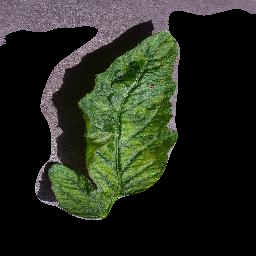

In [ ]:
cv2_imshow(cv2.bitwise_and(im_color,im_color,mask=th3))

In [ ]:
#a = cv2.imread("random_bkgrnd1.jpg",cv2.IMREAD_COLOR)
a = Image.open("random_bkgrnd1.jpg")
a = transforms.Resize(224)(a)
a = cv2.cvtColor(np.array(a),cv2.COLOR_BGR2RGB)
cv2_imshow(a)

In [ ]:
#def apply_random_back(,background):

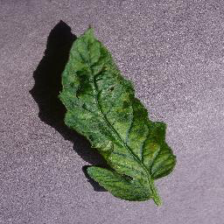

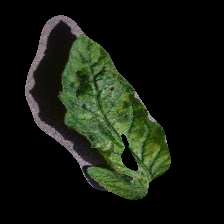

In [ ]:
#img = cv2.imread("IMG2.JPG", cv.IMREAD_COLOR)
img = Image.open("IMG.JPG")
img = transforms.Resize(224)(img)
img  = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
x = apply_mask(img)

In [ ]:
a = image_dict_saved["TOMATO"][1]
b = label_dict_saved["TOMATO"][1]
c = plantdoc_image_dict_saved["TOMATO"][1]
d = plantdoc_label_dict_saved["TOMATO"][1]

In [ ]:
a.size()

torch.Size([3, 224, 224])

In [ ]:
a = transforms.ToPILImage()(a)
c = transforms.ToPILImage()(c)

In [ ]:
a.size

(224, 224)

In [ ]:
apply_mask(a,c)

In [ ]:
pd_img = Image.open("pd_img.jpg")
pv_img = Image.open("pv_img.JPG")

In [ ]:
np.array(pv_img).shape

(256, 256, 3)

In [ ]:
pd_img = transforms.ToTensor()(pd_img)
pv_img = transforms.ToTensor()(pv_img)

In [ ]:
a = transforms.Resize((224,224))(pd_img)
b = transforms.Resize((224,224))(pv_img)

In [ ]:
a.size()

torch.Size([3, 224, 224])

In [ ]:
apply(pv_img,pd_img)

In [ ]:
z = x.copy()

In [ ]:
z[x==0] = 255
z[x>0] = 0

In [ ]:
k = x.copy()
k[x==0] = 255

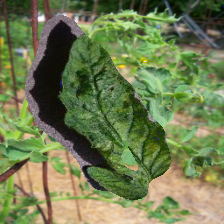

In [ ]:
cv2_imshow(cv2.bitwise_and(z,pdoc) + k)

In [ ]:
pdoc = Image.open("IMG2.jpg")
pdoc = transforms.Resize((224,224))(pdoc)
pdoc  = cv2.cvtColor(np.array(pdoc),cv2.COLOR_BGR2RGB)

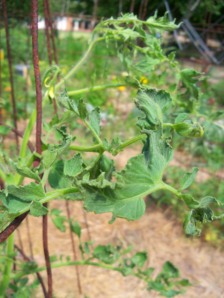

In [ ]:
cv2_imshow(pdoc)

In [ ]:
x[x==0] = 255

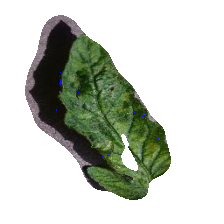

In [ ]:
cv2.bitwise

In [ ]:
u = Image.open("pv_img.JPG")

In [ ]:
get_mask(np.array(u))

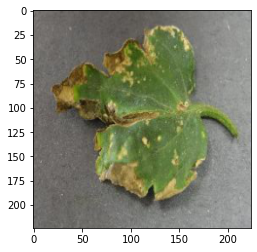

In [ ]:
k = (image_dict_saved["TOMATO"][2].numpy()*0.5)+0.5
plt.imshow(np.transpose(k,(2,1,0)))
#plt.imshow(k)

In [ ]:
u = torch.Tensor(((image_dict_saved["TOMATO"][2].numpy()*0.5)+0.5))
v = torch.Tensor((plantdoc_image_dict_saved["TOMATO"][2].numpy()*0.5)+0.5)
p = transforms.ToPILImage()(u)
q = transforms.ToPILImage()(v)
apply_mask(p,q)

In [ ]:
cv2_imshow(transforms.ToPILImage()(new_dataset_imgs["TOMATO"][5]))

In [ ]:
def unnormalize(img_tensor):
    x = img_tensor.numpy()
    x = (x*0.5)+0.5
    return torch.Tensor(x)

In [ ]:
a = torch.Tensor((x_i.numpy()*0.5+0.5))

In [ ]:
x = transforms.ToPILImage()(a)

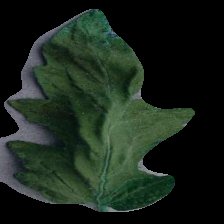

In [ ]:
cv2_imshow(get_mask(np.array(x)))

In [ ]:
get_mask(x)

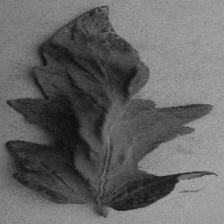

In [ ]:
im_gray = cv2.cvtColor(x,cv2.COLOR_BGR2GRAY)
cv2_imshow(im_gray*255)

In [ ]:
x_i = image_dict_saved["TOMATO"][100]
x_l = label_dict_saved["TOMATO"][100]
y_i = plantdoc_image_dict_saved["TOMATO"][20]
y_l = plantdoc_label_dict_saved["TOMATO"][20]

In [ ]:
(x_i.numpy()*0.5)+0.5

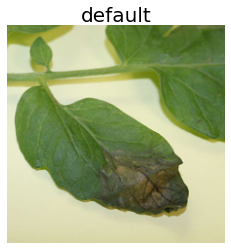

In [ ]:
print_image(y_i)

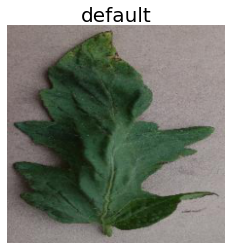

In [ ]:
#a = x_i.unsqueese(0)
print_image(x_i)

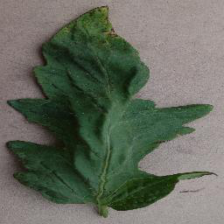

In [ ]:
cv2_imshow(cv2.cvtColor(np.transpose((x_i.numpy()*0.5+0.5)*255,(1,2,0)),cv2.COLOR_BGR2RGB))

In [ ]:
transforms.ToPILImage()((x_i.numpy()*0.5+0.5)*255)

In [ ]:
cv2_imshow(np.transpose((x_i.numpy()*0.5)+0.5,(1,2,0)))

In [ ]:
plantdoc_image_dict_saved["TOMATO"][1].size()

torch.Size([3, 224, 224])

##NEW MODEL

In [ ]:
class custom_block(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(inception_block,self).__init__()
        o1 = int(out_channels/4)
        o2 = int(out_channels/2)
        o3 = int(out_channels/8)
        o4 = int(out_channels/8)
        self.inc1 = nn.Conv2d(in_channels,o1,1)
        self.inc2 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o2,3,padding=1)
        )
        self.inc3 = nn.Sequential(
            nn.Conv2d(in_channels,512,1),
            nn.Conv2d(512,o3,5,padding=2)
        )
        self.inc4 = nn.Sequential(
            nn.MaxPool2d(3,1,1),
            nn.Conv2d(in_channels,o4,1)
        )

    def forward(self,x):
        x1 = self.inc1(x)
        #print(x1.size())
        x2 = self.inc2(x)
        #print(x2.size())
        x3 = self.inc3(x)
        #print(x3.size())
        x4 = self.inc4(x)
        #print(x4.size())

        return torch.cat((x1,x2,x3,x4),1)

In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

##RESNEXT

###PlantVillage

####Model Definition

In [ ]:
resnext = torch.hub.load('pytorch/vision:v0.9.0', 'resnext50_32x4d', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [ ]:
print(resnext)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
for param in resnext.parameters():
    param.requires_grad_(False)

In [ ]:
# new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
# in_features6 = vgg.classifier[6].in_features
# vgg.classifier[6] = nn.Sequential(
#                  nn.Linear(in_features6,new_out_features),
#                  nn.Softmax())
# in_features3 = vgg.classifier[3].in_features
# out_features3 = vgg.classifier[3].out_features
# vgg.classifier[3] = nn.Linear(in_features3,out_features3)

# in_features0 = vgg.classifier[0].in_features
# out_features0 = vgg.classifier[0].out_features
# vgg.classifier[0] = nn.Linear(in_features0,out_features0)

####Training

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(image_dict_saved["TOMATO"],
                                               label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=label_dict_saved["TOMATO"],
                                               random_state=0)

Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
train_img_dict = {}
val_img_dict={}
train_label_dict={}
val_label_dict={}
train_img_dict["TOMATO"] = X_train
val_img_dict["TOMATO"] = X_val
train_label_dict["TOMATO"] = Y_L_train
val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,train_img_dict,train_label_dict)
val_data = PlantImageDataloader(path,image_transform,val_img_dict,val_label_dict)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
resnext_loss_arr,best_resnext = train_batch(resnext,criterion,train_data,lr=0.0005,batch_size=64,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(best_resnext,val_data,128,device=device_gpu)

In [ ]:
torch.save(best_resnext,"plantvillage_benchmark_resnext1.1")

###PlantDoc

####Model Definition

In [ ]:
resnext_plantdoc = torch.hub.load('pytorch/vision:v0.9.0', 'resnext50_32x4d', pretrained=True)

In [ ]:
for param in resnext_plantdoc.parameters():
    param.requires_grad_(False)

In [ ]:
# new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
# in_features6 = vgg_plantdoc.classifier[6].in_features
# vgg_plantdoc.classifier[6] = nn.Sequential(
#                  nn.Linear(in_features6,new_out_features),
#                  nn.Softmax())
# in_features3 = vgg_plantdoc.classifier[3].in_features
# out_features3 = vgg_plantdoc.classifier[3].out_features
# vgg_plantdoc.classifier[3] = nn.Linear(in_features3,out_features3)

# in_features0 = vgg_plantdoc.classifier[0].in_features
# out_features0 = vgg_plantdoc.classifier[0].out_features
# vgg_plantdoc.classifier[0] = nn.Linear(in_features0,out_features0)

####Training

In [ ]:
X_train_plantdoc,X_val_plantdoc,Y_train_plantdoc,Y_val_plantdoc = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.15,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc = le.transform(Y_train_plantdoc)
Y_L_val_plantdoc = le.transform(Y_val_plantdoc)

In [ ]:
plantdoc_train_img_dict = {}
plantdoc_val_img_dict={}
plantdoc_train_label_dict={}
plantdoc_val_label_dict={}
plantdoc_train_img_dict["TOMATO"] = X_train_plantdoc
plantdoc_val_img_dict["TOMATO"] = X_val_plantdoc
plantdoc_train_label_dict["TOMATO"] = Y_L_train_plantdoc
plantdoc_val_label_dict["TOMATO"] = Y_L_val_plantdoc

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict,plantdoc_train_label_dict)
plantdoc_val_data = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict,plantdoc_val_label_dict)

In [ ]:
l_resnext,bm_resnext = train_batch(resnext_plantdoc,criterion,plantdoc_train_data,lr=0.000001,batch_size=128,epochs=500,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_resnext,plantdoc_val_data,128,device=device_gpu)

In [ ]:
torch.save(bm_resnext,"plantdoc_benchmark_resnext1.1")

###New Image Dataset

####Model Definition

In [ ]:
resnext_newdataset = torch.hub.load('pytorch/vision:v0.9.0', 'resnext50_32x4d', pretrained=True)

In [ ]:
for param in resnext_newdataset.parameters():
    param.requires_grad_(False)

In [ ]:
# new_out_features = 10           #total number of diseases for tomato in our dataset. Here we have 10 diseases in total
# in_features6 = vgg_newdataset.classifier[6].in_features
# vgg_newdataset.classifier[6] = nn.Sequential(
#                  nn.Linear(in_features6,new_out_features),
#                  nn.Softmax())
# in_features3 = vgg_newdataset.classifier[3].in_features
# out_features3 = vgg_newdataset.classifier[3].out_features
# vgg_newdataset.classifier[3] = nn.Linear(in_features3,out_features3)

# in_features0 = vgg_newdataset.classifier[0].in_features
# out_features0 = vgg_newdataset.classifier[0].out_features
# vgg_newdataset.classifier[0] = nn.Linear(in_features0,out_features0)

####Training

In [ ]:
X_train_plantdoc2,X_val_plantdoc2,Y_train_plantdoc2,Y_val_plantdoc2 = train_test_split(plantdoc_image_dict_saved["TOMATO"],
                                               plantdoc_label_dict_saved["TOMATO"],
                                               test_size=0.95,
                                               stratify=plantdoc_label_dict_saved["TOMATO"],
                                               random_state=0)

In [ ]:
Y_L_train_plantdoc2 = le.transform(Y_train_plantdoc2)
Y_L_val_plantdoc2 = le.transform(Y_val_plantdoc2)

In [ ]:
plantdoc_train_img_dict2 = {}
plantdoc_val_img_dict2={}
plantdoc_train_label_dict2={}
plantdoc_val_label_dict2={}
plantdoc_train_img_dict2["TOMATO"] = X_train_plantdoc2
plantdoc_val_img_dict2["TOMATO"] = X_val_plantdoc2
plantdoc_train_label_dict2["TOMATO"] = Y_L_train_plantdoc2
plantdoc_val_label_dict2["TOMATO"] = Y_L_val_plantdoc2

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantDoc"
plantdoc_train_data2 = PlantImageDataloader2(path,image_transform,plantdoc_train_img_dict2,plantdoc_train_label_dict2)
plantdoc_val_data2 = PlantImageDataloader2(path,image_transform,plantdoc_val_img_dict2,plantdoc_val_label_dict2)

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(new_dataset_imgs["TOMATO"],
                                               new_dataset_labels["TOMATO"],
                                               test_size=0.15,
                                               stratify=new_dataset_labels["TOMATO"],
                                               random_state=0)

Y_L_train = le.transform(Y_train)           #labels encoding to be used for the cross entropy loss function
Y_L_val = le.transform(Y_val)

In [ ]:
new_dataset_train_img_dict = {}
new_dataset_val_img_dict={}
new_dataset_train_label_dict={}
new_dataset_val_label_dict={}
new_dataset_train_img_dict["TOMATO"] = X_train
new_dataset_val_img_dict["TOMATO"] = X_val
new_dataset_train_label_dict["TOMATO"] = Y_L_train
new_dataset_val_label_dict["TOMATO"] = Y_L_val

path = f"drive/My Drive/Aditya Arnav-CropDisease/Dataset/PlantVillage"
train_data = PlantImageDataloader(path,image_transform,new_dataset_train_img_dict,new_dataset_train_label_dict)
val_data = PlantImageDataloader(path,image_transform,new_dataset_val_img_dict,new_dataset_val_label_dict)

In [ ]:
l_resnext,bm_resnext = train_batch(resnext_newdataset,criterion,train_data,lr=0.00001,batch_size=128,epochs=1000,display=True,device=device_gpu)

In [ ]:
calc_accuracy(bm_resnext,val_data,128,device=device_gpu)

In [ ]:
calc_accuracy(bm_resnext,plantdoc_val_data2,128,device=device_gpu)

In [ ]:
torch.save(bm_resnext,"newdataset_benchmark_resnext1.1")

##CsPNet

In [ ]:
!pip install timm

     |████████████████████████████████| 296kB 6.5MB/s 


In [ ]:
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from .helpers import build_model_with_cfg
from .layers import ClassifierHead, ConvBnAct, DropPath, create_attn, get_norm_act_layer
from .registry import register_model

In [ ]:
__all__ = ['CspNet']  # model_registry will add each entrypoint fn to this


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 256, 256), 'pool_size': (8, 8),
        'crop_pct': 0.887, 'interpolation': 'bilinear',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'stem.conv1.conv', 'classifier': 'head.fc',
        **kwargs
    }


default_cfgs = {
    'cspresnet50': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/cspresnet50_ra-d3e8d487.pth'),
    'cspresnet50d': _cfg(url=''),
    'cspresnet50w': _cfg(url=''),
    'cspresnext50': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/cspresnext50_ra_224-648b4713.pth',
        input_size=(3, 224, 224), pool_size=(7, 7), crop_pct=0.875  # FIXME I trained this at 224x224, not 256 like ref impl
    ),
    'cspresnext50_iabn': _cfg(url=''),
    'cspdarknet53': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/cspdarknet53_ra_256-d05c7c21.pth'),
    'cspdarknet53_iabn': _cfg(url=''),
    'darknet53': _cfg(url=''),
}


model_cfgs = dict(
    cspresnet50=dict(
        stem=dict(out_chs=64, kernel_size=7, stride=2, pool='max'),
        stage=dict(
            out_chs=(128, 256, 512, 1024),
            depth=(3, 3, 5, 2),
            stride=(1,) + (2,) * 3,
            exp_ratio=(2.,) * 4,
            bottle_ratio=(0.5,) * 4,
            block_ratio=(1.,) * 4,
            cross_linear=True,
        )
    ),
    cspresnet50d=dict(
        stem=dict(out_chs=[32, 32, 64], kernel_size=3, stride=2, pool='max'),
        stage=dict(
            out_chs=(128, 256, 512, 1024),
            depth=(3, 3, 5, 2),
            stride=(1,) + (2,) * 3,
            exp_ratio=(2.,) * 4,
            bottle_ratio=(0.5,) * 4,
            block_ratio=(1.,) * 4,
            cross_linear=True,
        )
    ),
    cspresnet50w=dict(
        stem=dict(out_chs=[32, 32, 64], kernel_size=3, stride=2, pool='max'),
        stage=dict(
            out_chs=(256, 512, 1024, 2048),
            depth=(3, 3, 5, 2),
            stride=(1,) + (2,) * 3,
            exp_ratio=(1.,) * 4,
            bottle_ratio=(0.25,) * 4,
            block_ratio=(0.5,) * 4,
            cross_linear=True,
        )
    ),
    cspresnext50=dict(
        stem=dict(out_chs=64, kernel_size=7, stride=2, pool='max'),
        stage=dict(
            out_chs=(256, 512, 1024, 2048),
            depth=(3, 3, 5, 2),
            stride=(1,) + (2,) * 3,
            groups=(32,) * 4,
            exp_ratio=(1.,) * 4,
            bottle_ratio=(1.,) * 4,
            block_ratio=(0.5,) * 4,
            cross_linear=True,
        )
    ),
    cspdarknet53=dict(
        stem=dict(out_chs=32, kernel_size=3, stride=1, pool=''),
        stage=dict(
            out_chs=(64, 128, 256, 512, 1024),
            depth=(1, 2, 8, 8, 4),
            stride=(2,) * 5,
            exp_ratio=(2.,) + (1.,) * 4,
            bottle_ratio=(0.5,) + (1.0,) * 4,
            block_ratio=(1.,) + (0.5,) * 4,
            down_growth=True,
        )
    ),
    darknet53=dict(
        stem=dict(out_chs=32, kernel_size=3, stride=1, pool=''),
        stage=dict(
            out_chs=(64, 128, 256, 512, 1024),
            depth=(1, 2, 8, 8, 4),
            stride=(2,) * 5,
            bottle_ratio=(0.5,) * 5,
            block_ratio=(1.,) * 5,
        )
    )
)


def create_stem(
        in_chans=3, out_chs=32, kernel_size=3, stride=2, pool='',
        act_layer=None, norm_layer=None, aa_layer=None):
    stem = nn.Sequential()
    if not isinstance(out_chs, (tuple, list)):
        out_chs = [out_chs]
    assert len(out_chs)
    in_c = in_chans
    for i, out_c in enumerate(out_chs):
        conv_name = f'conv{i + 1}'
        stem.add_module(conv_name, ConvBnAct(
            in_c, out_c, kernel_size, stride=stride if i == 0 else 1,
            act_layer=act_layer, norm_layer=norm_layer))
        in_c = out_c
        last_conv = conv_name
    if pool:
        if aa_layer is not None:
            stem.add_module('pool', nn.MaxPool2d(kernel_size=3, stride=1, padding=1))
            stem.add_module('aa', aa_layer(channels=in_c, stride=2))
        else:
            stem.add_module('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    return stem, dict(num_chs=in_c, reduction=stride, module='.'.join(['stem', last_conv]))


class ResBottleneck(nn.Module):
    """ ResNe(X)t Bottleneck Block
    """

    def __init__(self, in_chs, out_chs, dilation=1, bottle_ratio=0.25, groups=1,
                 act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d, attn_last=False,
                 attn_layer=None, aa_layer=None, drop_block=None, drop_path=None):
        super(ResBottleneck, self).__init__()
        mid_chs = int(round(out_chs * bottle_ratio))
        ckwargs = dict(act_layer=act_layer, norm_layer=norm_layer, aa_layer=aa_layer, drop_block=drop_block)

        self.conv1 = ConvBnAct(in_chs, mid_chs, kernel_size=1, **ckwargs)
        self.conv2 = ConvBnAct(mid_chs, mid_chs, kernel_size=3, dilation=dilation, groups=groups, **ckwargs)
        self.attn2 = create_attn(attn_layer, channels=mid_chs) if not attn_last else None
        self.conv3 = ConvBnAct(mid_chs, out_chs, kernel_size=1, apply_act=False, **ckwargs)
        self.attn3 = create_attn(attn_layer, channels=out_chs) if attn_last else None
        self.drop_path = drop_path
        self.act3 = act_layer(inplace=True)

    def zero_init_last_bn(self):
        nn.init.zeros_(self.conv3.bn.weight)

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.attn2 is not None:
            x = self.attn2(x)
        x = self.conv3(x)
        if self.attn3 is not None:
            x = self.attn3(x)
        if self.drop_path is not None:
            x = self.drop_path(x)
        x = x + shortcut
        # FIXME partial shortcut needed if first block handled as per original, not used for my current impl
        #x[:, :shortcut.size(1)] += shortcut
        x = self.act3(x)
        return x


class DarkBlock(nn.Module):
    """ DarkNet Block
    """

    def __init__(self, in_chs, out_chs, dilation=1, bottle_ratio=0.5, groups=1,
                 act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d, attn_layer=None, aa_layer=None,
                 drop_block=None, drop_path=None):
        super(DarkBlock, self).__init__()
        mid_chs = int(round(out_chs * bottle_ratio))
        ckwargs = dict(act_layer=act_layer, norm_layer=norm_layer, aa_layer=aa_layer, drop_block=drop_block)
        self.conv1 = ConvBnAct(in_chs, mid_chs, kernel_size=1, **ckwargs)
        self.conv2 = ConvBnAct(mid_chs, out_chs, kernel_size=3, dilation=dilation, groups=groups, **ckwargs)
        self.attn = create_attn(attn_layer, channels=out_chs)
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.conv2.bn.weight)

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.attn is not None:
            x = self.attn(x)
        if self.drop_path is not None:
            x = self.drop_path(x)
        x = x + shortcut
        return x


class CrossStage(nn.Module):
    """Cross Stage."""
    def __init__(self, in_chs, out_chs, stride, dilation, depth, block_ratio=1., bottle_ratio=1., exp_ratio=1.,
                 groups=1, first_dilation=None, down_growth=False, cross_linear=False, block_dpr=None,
                 block_fn=ResBottleneck, **block_kwargs):
        super(CrossStage, self).__init__()
        first_dilation = first_dilation or dilation
        down_chs = out_chs if down_growth else in_chs  # grow downsample channels to output channels
        exp_chs = int(round(out_chs * exp_ratio))
        block_out_chs = int(round(out_chs * block_ratio))
        conv_kwargs = dict(act_layer=block_kwargs.get('act_layer'), norm_layer=block_kwargs.get('norm_layer'))

        if stride != 1 or first_dilation != dilation:
            self.conv_down = ConvBnAct(
                in_chs, down_chs, kernel_size=3, stride=stride, dilation=first_dilation, groups=groups,
                aa_layer=block_kwargs.get('aa_layer', None), **conv_kwargs)
            prev_chs = down_chs
        else:
            self.conv_down = None
            prev_chs = in_chs

        # FIXME this 1x1 expansion is pushed down into the cross and block paths in the darknet cfgs. Also,
        # there is also special case for the first stage for some of the model that results in uneven split
        # across the two paths. I did it this way for simplicity for now.
        self.conv_exp = ConvBnAct(prev_chs, exp_chs, kernel_size=1, apply_act=not cross_linear, **conv_kwargs)
        prev_chs = exp_chs // 2  # output of conv_exp is always split in two

        self.blocks = nn.Sequential()
        for i in range(depth):
            drop_path = DropPath(block_dpr[i]) if block_dpr and block_dpr[i] else None
            self.blocks.add_module(str(i), block_fn(
                prev_chs, block_out_chs, dilation, bottle_ratio, groups, drop_path=drop_path, **block_kwargs))
            prev_chs = block_out_chs

        # transition convs
        self.conv_transition_b = ConvBnAct(prev_chs, exp_chs // 2, kernel_size=1, **conv_kwargs)
        self.conv_transition = ConvBnAct(exp_chs, out_chs, kernel_size=1, **conv_kwargs)

    def forward(self, x):
        if self.conv_down is not None:
            x = self.conv_down(x)
        x = self.conv_exp(x)
        xs, xb = x.chunk(2, dim=1)
        xb = self.blocks(xb)
        out = self.conv_transition(torch.cat([xs, self.conv_transition_b(xb)], dim=1))
        return out


class DarkStage(nn.Module):
    """DarkNet stage."""

    def __init__(self, in_chs, out_chs, stride, dilation, depth, block_ratio=1., bottle_ratio=1., groups=1,
                 first_dilation=None, block_fn=ResBottleneck, block_dpr=None, **block_kwargs):
        super(DarkStage, self).__init__()
        first_dilation = first_dilation or dilation

        self.conv_down = ConvBnAct(
            in_chs, out_chs, kernel_size=3, stride=stride, dilation=first_dilation, groups=groups,
            act_layer=block_kwargs.get('act_layer'), norm_layer=block_kwargs.get('norm_layer'),
            aa_layer=block_kwargs.get('aa_layer', None))

        prev_chs = out_chs
        block_out_chs = int(round(out_chs * block_ratio))
        self.blocks = nn.Sequential()
        for i in range(depth):
            drop_path = DropPath(block_dpr[i]) if block_dpr and block_dpr[i] else None
            self.blocks.add_module(str(i), block_fn(
                prev_chs, block_out_chs, dilation, bottle_ratio, groups, drop_path=drop_path, **block_kwargs))
            prev_chs = block_out_chs

    def forward(self, x):
        x = self.conv_down(x)
        x = self.blocks(x)
        return x


def _cfg_to_stage_args(cfg, curr_stride=2, output_stride=32, drop_path_rate=0.):
    # get per stage args for stage and containing blocks, calculate strides to meet target output_stride
    num_stages = len(cfg['depth'])
    if 'groups' not in cfg:
        cfg['groups'] = (1,) * num_stages
    if 'down_growth' in cfg and not isinstance(cfg['down_growth'], (list, tuple)):
        cfg['down_growth'] = (cfg['down_growth'],) * num_stages
    if 'cross_linear' in cfg and not isinstance(cfg['cross_linear'], (list, tuple)):
        cfg['cross_linear'] = (cfg['cross_linear'],) * num_stages
    cfg['block_dpr'] = [None] * num_stages if not drop_path_rate else \
        [x.tolist() for x in torch.linspace(0, drop_path_rate, sum(cfg['depth'])).split(cfg['depth'])]
    stage_strides = []
    stage_dilations = []
    stage_first_dilations = []
    dilation = 1
    for cfg_stride in cfg['stride']:
        stage_first_dilations.append(dilation)
        if curr_stride >= output_stride:
            dilation *= cfg_stride
            stride = 1
        else:
            stride = cfg_stride
            curr_stride *= stride
        stage_strides.append(stride)
        stage_dilations.append(dilation)
    cfg['stride'] = stage_strides
    cfg['dilation'] = stage_dilations
    cfg['first_dilation'] = stage_first_dilations
    stage_args = [dict(zip(cfg.keys(), values)) for values in zip(*cfg.values())]
    return stage_args


class CspNet(nn.Module):
    """Cross Stage Partial base model.
    Paper: `CSPNet: A New Backbone that can Enhance Learning Capability of CNN` - https://arxiv.org/abs/1911.11929
    Ref Impl: https://github.com/WongKinYiu/CrossStagePartialNetworks
    NOTE: There are differences in the way I handle the 1x1 'expansion' conv in this impl vs the
    darknet impl. I did it this way for simplicity and less special cases.
    """

    def __init__(self, cfg, in_chans=3, num_classes=1000, output_stride=32, global_pool='avg', drop_rate=0.,
                 act_layer=nn.LeakyReLU, norm_layer=nn.BatchNorm2d, aa_layer=None, drop_path_rate=0.,
                 zero_init_last_bn=True, stage_fn=CrossStage, block_fn=ResBottleneck):
        super().__init__()
        self.num_classes = num_classes
        self.drop_rate = drop_rate
        assert output_stride in (8, 16, 32)
        layer_args = dict(act_layer=act_layer, norm_layer=norm_layer, aa_layer=aa_layer)

        # Construct the stem
        self.stem, stem_feat_info = create_stem(in_chans, **cfg['stem'], **layer_args)
        self.feature_info = [stem_feat_info]
        prev_chs = stem_feat_info['num_chs']
        curr_stride = stem_feat_info['reduction']  # reduction does not include pool
        if cfg['stem']['pool']:
            curr_stride *= 2

        # Construct the stages
        per_stage_args = _cfg_to_stage_args(
            cfg['stage'], curr_stride=curr_stride, output_stride=output_stride, drop_path_rate=drop_path_rate)
        self.stages = nn.Sequential()
        for i, sa in enumerate(per_stage_args):
            self.stages.add_module(
                str(i), stage_fn(prev_chs, **sa, **layer_args, block_fn=block_fn))
            prev_chs = sa['out_chs']
            curr_stride *= sa['stride']
            self.feature_info += [dict(num_chs=prev_chs, reduction=curr_stride, module=f'stages.{i}')]

        # Construct the head
        self.num_features = prev_chs
        self.head = ClassifierHead(
            in_chs=prev_chs, num_classes=num_classes, pool_type=global_pool, drop_rate=drop_rate)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.zeros_(m.bias)
        if zero_init_last_bn:
            for m in self.modules():
                if hasattr(m, 'zero_init_last_bn'):
                    m.zero_init_last_bn()

    def get_classifier(self):
        return self.head.fc

    def reset_classifier(self, num_classes, global_pool='avg'):
        self.head = ClassifierHead(self.num_features, num_classes, pool_type=global_pool, drop_rate=self.drop_rate)

    def forward_features(self, x):
        x = self.stem(x)
        x = self.stages(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


def _create_cspnet(variant, pretrained=False, **kwargs):
    cfg_variant = variant.split('_')[0]
    return build_model_with_cfg(
        CspNet, variant, pretrained, default_cfg=default_cfgs[variant],
        feature_cfg=dict(flatten_sequential=True), model_cfg=model_cfgs[cfg_variant], **kwargs)


@register_model
def cspresnet50(pretrained=False, **kwargs):
    return _create_cspnet('cspresnet50', pretrained=pretrained, **kwargs)


@register_model
def cspresnet50d(pretrained=False, **kwargs):
    return _create_cspnet('cspresnet50d', pretrained=pretrained, **kwargs)


@register_model
def cspresnet50w(pretrained=False, **kwargs):
    return _create_cspnet('cspresnet50w', pretrained=pretrained, **kwargs)


@register_model
def cspresnext50(pretrained=False, **kwargs):
    return _create_cspnet('cspresnext50', pretrained=pretrained, **kwargs)


@register_model
def cspresnext50_iabn(pretrained=False, **kwargs):
    norm_layer = get_norm_act_layer('iabn')
    return _create_cspnet('cspresnext50_iabn', pretrained=pretrained, norm_layer=norm_layer, **kwargs)


@register_model
def cspdarknet53(pretrained=False, **kwargs):
    return _create_cspnet('cspdarknet53', pretrained=pretrained, block_fn=DarkBlock, **kwargs)


@register_model
def cspdarknet53_iabn(pretrained=False, **kwargs):
    norm_layer = get_norm_act_layer('iabn')
    return _create_cspnet('cspdarknet53_iabn', pretrained=pretrained, block_fn=DarkBlock, norm_layer=norm_layer, **kwargs)


@register_model
def darknet53(pretrained=False, **kwargs):
    return _create_cspnet('darknet53', pretrained=pretrained, block_fn=DarkBlock, stage_fn=DarkStage, **kwargs)
